In [ ]:
'''
=====Experiment=====
Dataset: BoT-IoT dataset

Host-Level Graph Construction
'''
DATASET_NAME = "BoT_IoT"

GRAPH_CONSTRUCTION = 'endpoint'
WINDOW_SIZE = 1500

MULTICLASS = True

from torch_geometric.utils import from_networkx, add_self_loops, degree
from torch_geometric.nn import MessagePassing
import torch_geometric.transforms as T
from torch_geometric.data import DataLoader
import torch.nn as nn
import torch as th
import torch.nn.functional as F
# import dgl.function as fn
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import numpy as np
import os
import sys
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from torch_geometric.loader import DataLoader

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
sys.path.append(project_root)

from Datasets.BoT_IoT.BoT_IoT_config import BoT_IoT_Config as Dataset_Config


In [ ]:
csv_file_name = "all_raw"

data = pd.read_csv(os.path.join(project_root, "Datasets", f"{DATASET_NAME}/All/{csv_file_name}.csv"))

In [ ]:
EXPERIMENT_NAME = f"strat_window_{GRAPH_CONSTRUCTION}_{WINDOW_SIZE}"

SOURCE_IP_COL_NAME = Dataset_Config.SOURCE_IP_COL_NAME
DESTINATION_IP_COL_NAME = Dataset_Config.DESTINATION_IP_COL_NAME
SOURCE_PORT_COL_NAME = Dataset_Config.SOURCE_PORT_COL_NAME
DESTINATION_PORT_COL_NAME = Dataset_Config.DESTINATION_PORT_COL_NAME

ATTACK_CLASS_COL_NAME = Dataset_Config.ATTACK_CLASS_COL_NAME
IS_ATTACK_COL_NAME = Dataset_Config.IS_ATTACK_COL_NAME

BENIGN_CLASS_NAME = Dataset_Config.BENIGN_CLASS_NAME

TIME_COLS = Dataset_Config.TIME_COL_NAMES

DROP_COLS = Dataset_Config.DROP_COLS

COLS_TO_NORM = Dataset_Config.COLS_TO_NORM
CATEGORICAL_COLS = Dataset_Config.CATEGORICAL_COLS

print(data[ATTACK_CLASS_COL_NAME].value_counts())
print(data[IS_ATTACK_COL_NAME].value_counts())

if MULTICLASS:
    label_col = ATTACK_CLASS_COL_NAME
    data.drop(columns=[IS_ATTACK_COL_NAME], inplace=True)
else:
    label_col = IS_ATTACK_COL_NAME
    data.drop(columns=[ATTACK_CLASS_COL_NAME], inplace=True)

save_path = os.path.join(project_root, "Models/E_GraphSAGE/saved", EXPERIMENT_NAME)

checkpoint_path = os.path.join(save_path, f"checkpoints_{csv_file_name}.pth")
best_model_path = os.path.join(save_path, f"best_model_{csv_file_name}.pth")

graph_datasets_path = os.path.join(save_path, GRAPH_CONSTRUCTION, str(WINDOW_SIZE))

os.makedirs(save_path, exist_ok=True)
os.makedirs(graph_datasets_path, exist_ok=True)

category
DDoS              1926624
DoS               1650260
Reconnaissance      91082
Normal                477
Theft                  79
Name: count, dtype: int64
attack
1    3668045
0        477
Name: count, dtype: int64


In [ ]:
data.drop(columns=DROP_COLS,inplace=True)
print(data.columns)

Index(['pkSeqID', 'stime', 'flgs_number', 'proto_number', 'saddr', 'sport',
       'daddr', 'dport', 'pkts', 'bytes', 'state_number', 'ltime', 'dur',
       'mean', 'stddev', 'sum', 'min', 'max', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'srate', 'drate', 'TnBPSrcIP', 'TnBPDstIP',
       'TnP_PSrcIP', 'TnP_PDstIP', 'TnP_PerProto', 'TnP_Per_Dport',
       'AR_P_Proto_P_SrcIP', 'AR_P_Proto_P_DstIP', 'N_IN_Conn_P_DstIP',
       'N_IN_Conn_P_SrcIP', 'AR_P_Proto_P_Sport', 'AR_P_Proto_P_Dport',
       'Pkts_P_State_P_Protocol_P_DestIP', 'Pkts_P_State_P_Protocol_P_SrcIP',
       'category'],
      dtype='object')


In [ ]:
if GRAPH_CONSTRUCTION == 'host':
    data[SOURCE_IP_COL_NAME] = data[SOURCE_IP_COL_NAME].apply(str)
    data[DESTINATION_IP_COL_NAME] = data[DESTINATION_IP_COL_NAME].apply(str)

    # # Combine Port and IP
    data[SOURCE_PORT_COL_NAME] = data[SOURCE_PORT_COL_NAME].apply(str)
    data[DESTINATION_PORT_COL_NAME] = data[DESTINATION_PORT_COL_NAME].apply(str)

    data[SOURCE_IP_COL_NAME] = data[SOURCE_IP_COL_NAME] + ':' + data[SOURCE_PORT_COL_NAME]
    data[DESTINATION_IP_COL_NAME] = data[DESTINATION_IP_COL_NAME] + ':' + data[DESTINATION_PORT_COL_NAME]
    data.drop(columns=[SOURCE_PORT_COL_NAME,DESTINATION_PORT_COL_NAME],inplace=True)

    data = pd.get_dummies(data, columns = CATEGORICAL_COLS) # One Hot Encoding for categorical data
    converted_categorical_cols = [col for col in data.columns if col.startswith(tuple(CATEGORICAL_COLS))]

elif GRAPH_CONSTRUCTION == 'endpoint':
    data = pd.get_dummies(data, columns = CATEGORICAL_COLS) # One Hot Encoding for categorical data
    converted_categorical_cols = [col for col in data.columns if col.startswith(tuple(CATEGORICAL_COLS))]
    COLS_TO_NORM = COLS_TO_NORM + [SOURCE_PORT_COL_NAME, DESTINATION_PORT_COL_NAME]
else:
    raise ValueError("Invalid GRAPH_CONSTRUCTION value. Use 'host' or 'endpoint'.")
    

In [ ]:
# Clean NaN values
data.reset_index(drop=True, inplace=True)
data.replace([np.inf, -np.inf], np.nan,inplace = True)
data.fillna(0,inplace = True)

In [ ]:
# Normalize numerical columns
scaler = StandardScaler()
print(data[COLS_TO_NORM].describe()) # Check if there's any too large value

# Check for numeric issues in the columns before normalization
def check_numeric_issues(df, cols_to_norm):
    for col in cols_to_norm:
        try:
            # Try to coerce to numeric
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
        except Exception as e:
            print(f"❌ Column '{col}' failed with error: {e}")
            print(f"  - Sample values: {df[col].dropna().unique()[:5]}")
            print(f"  - Data type: {df[col].dtype}")
            continue

    print("\n✅ All other columns processed successfully.")

check_numeric_issues(data, COLS_TO_NORM)

data[COLS_TO_NORM] = scaler.fit_transform(data[COLS_TO_NORM])

               pkts         bytes           dur          mean        stddev  \
count  3.668522e+06  3.668522e+06  3.668522e+06  3.668522e+06  3.668522e+06   
mean   7.725963e+00  8.690501e+02  2.033479e+01  2.231063e+00  8.871499e-01   
std    1.155876e+02  1.122667e+05  2.148764e+01  1.517728e+00  8.037139e-01   
min    1.000000e+00  6.000000e+01  0.000000e+00  0.000000e+00  0.000000e+00   
25%    5.000000e+00  4.200000e+02  1.256256e+01  1.819670e-01  3.001900e-02   
50%    7.000000e+00  6.000000e+02  1.550852e+01  2.690125e+00  7.938960e-01   
75%    9.000000e+00  7.700000e+02  2.709986e+01  3.565203e+00  1.745296e+00   
max    7.005700e+04  7.183334e+07  2.771485e+03  4.981882e+00  2.496763e+00   

                sum           min           max         spkts         dpkts  \
count  3.668522e+06  3.668522e+06  3.668522e+06  3.668522e+06  3.668522e+06   
mean   7.721635e+00  1.017540e+00  3.020015e+00  7.314146e+00  4.118173e-01   
std    7.616199e+00  1.483688e+00  1.860877e+00  7.

In [ ]:
num_classes = 2
class_map = [0, 1]
if MULTICLASS:
    le = LabelEncoder()
    attack_labels = le.fit_transform(data[ATTACK_CLASS_COL_NAME])
    class_map = le.classes_
    print(class_map)
    print("Attack label mapping:", dict(zip(class_map, range(len(class_map)))))
    data[ATTACK_CLASS_COL_NAME] = attack_labels
    num_classes = len(class_map)
    class_dict = {le.inverse_transform([i])[0]: i for i in range(len(le.classes_))}

BENIGN_CLASS_LABEL = le.transform([BENIGN_CLASS_NAME])[0] if MULTICLASS else 0
ADVERSARIAL_CLASS_LABEL = len(class_map)

['DDoS' 'DoS' 'Normal' 'Reconnaissance' 'Theft']
Attack label mapping: {'DDoS': 0, 'DoS': 1, 'Normal': 2, 'Reconnaissance': 3, 'Theft': 4}


In [ ]:
# # Maintain the order of the rows in the original dataframe
feature_cols = COLS_TO_NORM + converted_categorical_cols

print('Feature Columns:', feature_cols)
num_features = len(feature_cols)
print('Number of Features:', num_features)

data['h'] = data[ feature_cols ].values.tolist()

Feature Columns: ['pkts', 'bytes', 'dur', 'mean', 'stddev', 'sum', 'min', 'max', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'srate', 'drate', 'TnBPSrcIP', 'TnBPDstIP', 'TnP_PSrcIP', 'TnP_PDstIP', 'TnP_PerProto', 'TnP_Per_Dport', 'AR_P_Proto_P_SrcIP', 'AR_P_Proto_P_DstIP', 'N_IN_Conn_P_DstIP', 'N_IN_Conn_P_SrcIP', 'AR_P_Proto_P_Sport', 'AR_P_Proto_P_Dport', 'Pkts_P_State_P_Protocol_P_DestIP', 'Pkts_P_State_P_Protocol_P_SrcIP', 'flgs_number_1', 'flgs_number_2', 'flgs_number_3', 'flgs_number_4', 'flgs_number_5', 'flgs_number_6', 'flgs_number_7', 'flgs_number_8', 'flgs_number_9', 'state_number_1', 'state_number_2', 'state_number_3', 'state_number_4', 'state_number_5', 'state_number_6', 'state_number_7', 'state_number_8', 'state_number_9', 'state_number_10', 'state_number_11', 'proto_number_1', 'proto_number_2', 'proto_number_3', 'proto_number_4', 'proto_number_5']
Number of Features: 54


In [ ]:
print(data.head(5))

   pkSeqID         stime                saddr                daddr  \
0  3576925  1.526344e+09     192.168.100.3:80  192.168.100.55:8080   
1  3576926  1.526344e+09  192.168.100.46:3456     192.168.100.5:80   
2  3576919  1.526344e+09    192.168.100.46:80     192.168.100.5:80   
3  3576920  1.526344e+09    192.168.100.46:80     192.168.100.5:80   
4  3576922  1.526344e+09    192.168.100.7:365    192.168.100.3:565   

         pkts       bytes         ltime        dur      mean    stddev  ...  \
0  514.287519  542.313009  1.526346e+09  77.503750  1.790079 -0.819516  ...   
1  514.278867  526.543278  1.526346e+09  77.503750  1.789861 -0.815632  ...   
2  257.106013  254.240221  1.526346e+09  77.503750  1.789697 -0.815753  ...   
3  260.834786  257.403476  1.526346e+09  77.503750  1.789704 -0.815673  ...   
4  141.176650    8.717557  1.526346e+09  77.516146  1.754480 -0.815219  ...   

   state_number_8  state_number_9  state_number_10  state_number_11  \
0           False           False

In [ ]:
def create_graph(df):

    G_nx = nx.from_pandas_edgelist(df, SOURCE_IP_COL_NAME, DESTINATION_IP_COL_NAME, ['h', label_col], create_using=nx.MultiDiGraph())
    
    G_pyg = from_networkx(G_nx)

    num_nodes = G_pyg.num_nodes
    num_edges = G_pyg.num_edges

    assert num_edges == G_nx.number_of_edges(), "Number of edges in PyG graph does not match NetworkX graph."

    G_pyg.x = th.ones(num_nodes, len(df['h'].iloc[0])) 

    edge_attr_list = []
    edge_label_list = []

    for u, v, key, data in G_nx.edges(keys=True, data=True):
        edge_attr_list.append(data['h']) 
        edge_label_list.append(data[label_col]) 

    G_pyg.edge_attr = th.tensor(edge_attr_list, dtype=th.float32)
    G_pyg.edge_label = th.tensor(edge_label_list, dtype=th.long)

    return G_pyg

In [ ]:
from collections import defaultdict
from typing import Counter
from sklearn.preprocessing import MultiLabelBinarizer

from tqdm import tqdm

class StratifiedGraphDataset:

    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.total_count = len(self.y)

        # Compute class weights
        labels = []

        for graph in self.X:
            labels.append(graph.edge_label.tolist())

        labels = np.concatenate(labels)

        self.class_counts = Counter(labels)

        # Compute the class weights
        self.class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(labels),
            y=labels
        )

    def k_fold_split(self, k: int = 5, test_ratio: float = 0.15, random_state: int = 42):
        cv = MultilabelStratifiedShuffleSplit(test_size=test_ratio, random_state=random_state, n_splits=k)

        mlb = MultiLabelBinarizer()

        y_binary = mlb.fit_transform(self.y)

        return cv.split(np.zeros(len(self.X)), y_binary)

    def graph_train_test_split(self, test_ratio: float = 0.15, random_state: int = 42):
        train_idx, test_idx = next(self.k_fold_split(k = 1, test_ratio = test_ratio, random_state = random_state))
        
        X_train = [self.X[i] for i in train_idx]
        X_test = [self.X[i] for i in test_idx]

        y_train = [self.y[i] for i in train_idx]
        y_test = [self.y[i] for i in test_idx]

        return StratifiedGraphDataset(X_train, y_train), StratifiedGraphDataset(X_test, y_test)
    
    def print_class_distribution_and_weights(self):
        # Use the label encoder to inverse transform the class labels
        class_counts_named = {cls: count for cls, count in self.class_counts.items()}
        class_weights_named = {cls: weight for cls, weight in enumerate(self.class_weights)}
        print("Class Counts and Weights:")
        for cls_label in class_counts_named.keys():
            count = class_counts_named[cls_label]
            weight = class_weights_named[cls_label]
            print(f"{cls_label:<2}  {le.inverse_transform([cls_label])[0]:<15}: Count = {count:<10}, Weight = {weight:<10.4f}")
    
    def __len__(self):
        return self.total_count

    def __iter__(self):
        for g in self.X:
            yield g
            
    def __getitem__(self, idx):
        if isinstance(idx, int):
            return self.X[idx], self.y[idx]
        elif isinstance(idx, slice):
            return [self.X[i] for i in range(len(self.X))][idx], [self.y[i] for i in range(len(self.y))][idx]
        else:
            raise TypeError("Index must be an integer or a slice.")

def generate_graph_datasets(
    df: pd.DataFrame, 
    window_size: int = WINDOW_SIZE, 
    feature_cols=feature_cols,
    ordering_cols= TIME_COLS, 
    label_col=label_col,
    build_graph_func=create_graph,
    ):

    print("All Columns: ", df.columns)
    print("Ordering Columns: ", ordering_cols)
    assert all(col in df.columns for col in ordering_cols), "All timestamp columns are required"
    assert label_col in df.columns, "Edge label column 'label' is required"
    
    df = df.sort_values(ordering_cols).reset_index(drop=True)
    window_size = int(window_size)
    
    df.drop(columns=set(df.columns) - set(feature_cols) - set(label_col))

    print("Final Columns: ", df.columns)
    
    label_counts_list = []
    X = []
    y = []

    progress_bar = tqdm(range(0, len(df), window_size), desc=f"Generating graphs")
    for start in progress_bar:
        window_df = df[start: min(start + window_size, len(df))]
        contains_label = window_df[label_col].unique()

        G_pyg = build_graph_func(window_df)

        label_counts = window_df[label_col].value_counts()

        label_counts_list.append(label_counts)
        X.append(G_pyg)
        y.append(contains_label.tolist())

    return StratifiedGraphDataset(X, y)

In [ ]:
graph_dataset = generate_graph_datasets(data)
full_train_graph_dataset, test_graph_dataset = graph_dataset.graph_train_test_split(test_ratio=0.15, random_state=42)


All Columns:  Index(['pkSeqID', 'stime', 'saddr', 'daddr', 'pkts', 'bytes', 'ltime', 'dur',
       'mean', 'stddev', 'sum', 'min', 'max', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'srate', 'drate', 'TnBPSrcIP', 'TnBPDstIP',
       'TnP_PSrcIP', 'TnP_PDstIP', 'TnP_PerProto', 'TnP_Per_Dport',
       'AR_P_Proto_P_SrcIP', 'AR_P_Proto_P_DstIP', 'N_IN_Conn_P_DstIP',
       'N_IN_Conn_P_SrcIP', 'AR_P_Proto_P_Sport', 'AR_P_Proto_P_Dport',
       'Pkts_P_State_P_Protocol_P_DestIP', 'Pkts_P_State_P_Protocol_P_SrcIP',
       'category', 'flgs_number_1', 'flgs_number_2', 'flgs_number_3',
       'flgs_number_4', 'flgs_number_5', 'flgs_number_6', 'flgs_number_7',
       'flgs_number_8', 'flgs_number_9', 'state_number_1', 'state_number_2',
       'state_number_3', 'state_number_4', 'state_number_5', 'state_number_6',
       'state_number_7', 'state_number_8', 'state_number_9', 'state_number_10',
       'state_number_11', 'proto_number_1', 'proto_number_2', 'proto_number_3',
       'proto_

Generating graphs: 100%|██████████| 2446/2446 [03:03<00:00, 13.32it/s]


In [ ]:
print("Class Distrubution:", data[label_col].value_counts())

print("Number of graphs after downsampling:", len(graph_dataset))
graph_dataset.print_class_distribution_and_weights()

print("Number of training graphs:", len(full_train_graph_dataset))
full_train_graph_dataset.print_class_distribution_and_weights()

print("Number of testing graphs:", len(test_graph_dataset))
test_graph_dataset.print_class_distribution_and_weights()

Class Distrubution: category
0    1926624
1    1650260
3      91082
2        477
4         79
Name: count, dtype: int64
Number of graphs after downsampling: 2446
Class Counts and Weights:
2   Normal         : Count = 477       , Weight = 1538.1644 
3   Reconnaissance : Count = 91082     , Weight = 8.0554    
1   DoS            : Count = 1650260   , Weight = 0.4446    
0   DDoS           : Count = 1926624   , Weight = 0.3808    
4   Theft          : Count = 79        , Weight = 9287.3975 
Number of training graphs: 2080
Class Counts and Weights:
2   Normal         : Count = 449       , Weight = 1389.5421 
3   Reconnaissance : Count = 79051     , Weight = 7.8924    
1   DoS            : Count = 1402819   , Weight = 0.4448    
0   DDoS           : Count = 1637124   , Weight = 0.3811    
4   Theft          : Count = 79        , Weight = 7897.5241 
Number of testing graphs: 366
Class Counts and Weights:
3   Reconnaissance : Count = 12031     , Weight = 11.4080   
2   Normal         : Count 

In [ ]:
class SAGELayerPyG(MessagePassing):
    def __init__(self, in_channels, edge_dim, out_channels, activation=F.relu):
        super().__init__(aggr='mean')  # mean aggregation
        self.W_msg = nn.Linear(in_channels + edge_dim, out_channels)
        self.W_apply = nn.Linear(in_channels + out_channels, out_channels)
        self.activation = activation

    def forward(self, x, edge_index, edge_attr):
        # x: [num_nodes, in_channels]
        # edge_attr: [num_edges, edge_dim]
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_j, edge_attr):
        # x_j: features of source nodes (neighbours)
        msg_input = th.cat([x_j, edge_attr], dim=1)
        return self.W_msg(msg_input)

    def update(self, aggr_out, x):
        # aggr_out: [num_nodes, out_channels]
        combined = th.cat([x, aggr_out], dim=1)
        out = self.W_apply(combined)
        return self.activation(out)
    
class MLPPredictor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MLPPredictor, self).__init__()
        self.lin = nn.Linear(in_channels * 2, out_channels)

    def forward(self, data, z):
        row, col = data.edge_index
        # Concatenate the features of source and target nodes for each edge
        edge_feat = th.cat([z[row], z[col]], dim=1)
        return self.lin(edge_feat)

class EGraphSAGE(nn.Module):
    def __init__(self, node_in_channels, edge_in_channels, hidden_channels, out_channels, dropout=0.2):
        super(EGraphSAGE, self).__init__()
        self.dropout = dropout
        self.conv1 = SAGELayerPyG(node_in_channels, edge_in_channels, hidden_channels)
        self.conv2 = SAGELayerPyG(hidden_channels, edge_in_channels, hidden_channels)
        self.mlp_predictor = MLPPredictor(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        return self.mlp_predictor(data, x)

In [ ]:
device = th.device("cuda:0" if th.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
th.cuda.empty_cache()

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0)

In [ ]:
from sklearn.metrics import f1_score

def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

def grid_search(graph_dataset, patience, max_epochs, learning_rates, hidden_dims, drop_outs, folds=3):
    global num_features
    
    best_params = {}
    best_f1 = 0
    params_results = {}

    # Precompute the train and validation graphs for all folds
    folds_list = []
    for i in range(folds):
        train_graph_dataset, val_graph_dataset = graph_dataset.graph_train_test_split(test_ratio=0.15, random_state=i)
        folds_list.append((train_graph_dataset, val_graph_dataset))

    for lr in learning_rates:
        for hidden_dim in hidden_dims:
            for drop_out in drop_outs:
                print(f"Testing with learning rate: {lr}, hidden_dim: {hidden_dim}, drop_out: {drop_out}")
                fold_f1_scores = []

                for fold, (train_graph_dataset, val_graph_dataset) in enumerate(folds_list):
                    print(f"Fold {fold + 1}")

                    model = EGraphSAGE(node_in_channels=num_features,
                                    edge_in_channels=num_features,
                                    hidden_channels=hidden_dim,
                                    dropout = drop_out,
                                    out_channels=num_classes).to(device)

                    model.apply(init_weights)

                    # Normalize to stabilize training
                    class_weights = th.FloatTensor(train_graph_dataset.class_weights).to(device)
                    print("Class weights:", class_weights)

                    criterion = nn.CrossEntropyLoss(weight=class_weights)
                    optimizer = th.optim.Adam(model.parameters(), lr=lr)
                    scheduler = th.optim.lr_scheduler.ReduceLROnPlateau(
                        optimizer,
                        mode='min',
                        factor=0.6,
                        patience=5,
                        min_lr=1e-6,
                    )

                    best_epoch_f1 = 0  # Track the best F1 score for this fold
                    best_val_loss = float('inf')  # Track the best val_loss for this fold
                    patience_counter = 0

                    for epoch in range(max_epochs):
                        try:
                            train_loss = 0
                            val_loss = 0
                            num_train_graphs = len(train_graph_dataset)
                            num_val_graphs = len(val_graph_dataset)

                            model.train()
                            for G_pyg_train in tqdm(train_graph_dataset, desc="Training", leave=False):
                                optimizer.zero_grad()

                                G_pyg_train = G_pyg_train.to(device)
                                G_pyg_train.edge_label = G_pyg_train.edge_label.to(device)
                                G_pyg_train.edge_attr = G_pyg_train.edge_attr.to(device)
                                
                                out = model(G_pyg_train)
                                loss = criterion(out, G_pyg_train.edge_label) / num_train_graphs
                                train_loss += loss.item()

                                loss.backward()

                                optimizer.step()
                            

                            test_label_list = []
                            pred_label_list = []

                            model.eval()
                            with th.no_grad():
                                for G_pyg_val in tqdm(val_graph_dataset, desc="Validation", leave=False):

                                    G_pyg_val = G_pyg_val.to(device)
                                    G_pyg_val.edge_label = G_pyg_val.edge_label.to(device)
                                    G_pyg_val.edge_attr = G_pyg_val.edge_attr.to(device)

                                    out = model(G_pyg_val)
                                    loss = criterion(out, G_pyg_val.edge_label) / num_val_graphs
                                    val_loss += loss.item()

                                    test_label_list.append(G_pyg_val.edge_label.cpu())
                                    pred_label_list.append(out.argmax(dim=1).cpu())

                            test_label = th.cat(test_label_list)
                            pred_label = th.cat(pred_label_list)

                            val_f1 = f1_score(test_label, pred_label, average='weighted')
                            val_f1_micro = f1_score(test_label, pred_label, average='micro')
                            val_f1_macro = f1_score(test_label, pred_label, average='macro')

                            # Schedule step
                            scheduler.step(val_loss)

                            if val_f1 > best_epoch_f1:
                                best_epoch_f1 = val_f1
                                print(f"Epoch {epoch}/{max_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                                f"Val F1 (weighted): {val_f1:.4f}, Micro: {val_f1_micro:.4f}, Macro: {val_f1_macro:.4f} "
                                f"(Best Weighted F1 so far: {best_epoch_f1:.4f})")

                            # Early stopping condition
                            if val_loss < best_val_loss:
                                best_val_loss = val_loss
                                patience_counter = 0
                            else:
                                patience_counter += 1

                            if patience_counter >= patience:
                                print(f"\n🛑 Early stopping triggered at epoch {epoch}.")
                                break

                        except Exception as e:
                            print(f"An error occurred at epoch {epoch}: {str(e)}")
                            break

                    fold_f1_scores.append(best_epoch_f1)  # Append the best F1 score for this fold
                
                avg_f1 = sum(fold_f1_scores) / len(fold_f1_scores)
                params_results[(drop_out, lr, hidden_dim)] = {'folds': fold_f1_scores, 'avg_f1': avg_f1}
                print(f"Average F1 Score for drop_out {drop_out}, learning rate {lr}, hidden_dim {hidden_dim}: {avg_f1:.4f}")

                if avg_f1 > best_f1:
                    best_f1 = avg_f1
                    best_params = {'learning_rate': lr, 'hidden_dim': hidden_dim, 'drop_out': drop_out}

    print(f"Best Parameters: {best_params}, Best F1 Score: {best_f1:.4f}")
    print("All results:", params_results)

# grid_search(
#     full_train_graph_dataset, 
#     patience=10,
#     max_epochs=200,
#     learning_rates=[0.001, 0.005, 0.01, 0.05], 
#     hidden_dims=[128, 256, 512], 
#     drop_outs=[0.2, 0.3, 0.4],
#     folds=3)


Testing with learning rate: 0.001, hidden_dim: 128, drop_out: 0.2
Fold 1
Class weights: tensor([3.8121e-01, 4.4458e-01, 1.9641e+03, 7.8879e+00, 6.7127e+03],
       device='cuda:0')


Epoch 1/200, Train Loss: 0.0717, Val Loss: 8.1863, Val F1 (weighted): 0.3623, Micro: 0.5257, Macro: 0.1917 (Best Weighted F1 so far: 0.3623)


Epoch 2/200, Train Loss: 0.0710, Val Loss: 10.4915, Val F1 (weighted): 0.3673, Micro: 0.5281, Macro: 0.2739 (Best Weighted F1 so far: 0.3673)


Epoch 3/200, Train Loss: 0.0626, Val Loss: 6.8126, Val F1 (weighted): 0.3679, Micro: 0.5285, Macro: 0.3972 (Best Weighted F1 so far: 0.3679)


Epoch 5/200, Train Loss: 0.0948, Val Loss: 7.2049, Val F1 (weighted): 0.3686, Micro: 0.5289, Macro: 0.3325 (Best Weighted F1 so far: 0.3686)


Epoch 6/200, Train Loss: 0.0871, Val Loss: 11.7522, Val F1 (weighted): 0.3696, Micro: 0.5291, Macro: 0.3330 (Best Weighted F1 so far: 0.3696)


Epoch 7/200, Train Loss: 0.0895, Val Loss: 7.3584, Val F1 (weighted): 0.3718, Micro: 0.5306, Macro: 0.3210 (Best Weighted F1 so far: 0.3718)


Epoch 8/200, Train Loss: 0.0655, Val Loss: 7.5776, Val F1 (weighted): 0.3751, Micro: 0.5328, Macro: 0.3232 (Best Weighted F1 so far: 0.3751)


Epoch 10/200, Train Loss: 0.0948, Val Loss: 6.9493, Val F1 (weighted): 0.3770, Micro: 0.5341, Macro: 0.3253 (Best Weighted F1 so far: 0.3770)


Epoch 11/200, Train Loss: 0.1386, Val Loss: 7.1581, Val F1 (weighted): 0.3777, Micro: 0.5345, Macro: 0.3939 (Best Weighted F1 so far: 0.3777)


Epoch 12/200, Train Loss: 0.0819, Val Loss: 4.8119, Val F1 (weighted): 0.3792, Micro: 0.5355, Macro: 0.4000 (Best Weighted F1 so far: 0.3792)


Epoch 13/200, Train Loss: 0.1149, Val Loss: 3.3922, Val F1 (weighted): 0.3848, Micro: 0.5394, Macro: 0.4078 (Best Weighted F1 so far: 0.3848)


Epoch 23/200, Train Loss: 0.0330, Val Loss: 3.0852, Val F1 (weighted): 0.3997, Micro: 0.5484, Macro: 0.4588 (Best Weighted F1 so far: 0.3997)


Epoch 24/200, Train Loss: 0.0308, Val Loss: 2.0661, Val F1 (weighted): 0.5078, Micro: 0.6035, Macro: 0.5482 (Best Weighted F1 so far: 0.5078)


Epoch 28/200, Train Loss: 0.0233, Val Loss: 1.4392, Val F1 (weighted): 0.6304, Micro: 0.6771, Macro: 0.5407 (Best Weighted F1 so far: 0.6304)


Epoch 31/200, Train Loss: 0.0174, Val Loss: 1.1901, Val F1 (weighted): 0.7595, Micro: 0.7754, Macro: 0.6412 (Best Weighted F1 so far: 0.7595)


Epoch 33/200, Train Loss: 0.0125, Val Loss: 0.8678, Val F1 (weighted): 0.8301, Micro: 0.8370, Macro: 0.6697 (Best Weighted F1 so far: 0.8301)


Epoch 37/200, Train Loss: 0.0194, Val Loss: 0.6534, Val F1 (weighted): 0.8743, Micro: 0.8776, Macro: 0.6942 (Best Weighted F1 so far: 0.8743)


Epoch 45/200, Train Loss: 0.0120, Val Loss: 0.7201, Val F1 (weighted): 0.8914, Micro: 0.8937, Macro: 0.7108 (Best Weighted F1 so far: 0.8914)


Epoch 46/200, Train Loss: 0.0103, Val Loss: 0.7028, Val F1 (weighted): 0.8961, Micro: 0.8979, Macro: 0.7346 (Best Weighted F1 so far: 0.8961)


Epoch 47/200, Train Loss: 0.0108, Val Loss: 0.7684, Val F1 (weighted): 0.8966, Micro: 0.8985, Macro: 0.7264 (Best Weighted F1 so far: 0.8966)

🛑 Early stopping triggered at epoch 46.
Fold 2
Class weights: tensor([3.8133e-01, 4.4439e-01, 2.0408e+03, 7.8912e+00, 6.7165e+03],
       device='cuda:0')


Epoch 1/200, Train Loss: 0.0725, Val Loss: 7.9024, Val F1 (weighted): 0.3635, Micro: 0.5267, Macro: 0.2276 (Best Weighted F1 so far: 0.3635)


Epoch 2/200, Train Loss: 0.0905, Val Loss: 7.2324, Val F1 (weighted): 0.3637, Micro: 0.5269, Macro: 0.3345 (Best Weighted F1 so far: 0.3637)


Epoch 3/200, Train Loss: 0.1069, Val Loss: 6.4211, Val F1 (weighted): 0.3681, Micro: 0.5290, Macro: 0.3610 (Best Weighted F1 so far: 0.3681)


Epoch 4/200, Train Loss: 0.0979, Val Loss: 9.5921, Val F1 (weighted): 0.3683, Micro: 0.5291, Macro: 0.3941 (Best Weighted F1 so far: 0.3683)


Epoch 5/200, Train Loss: 0.0900, Val Loss: 7.9985, Val F1 (weighted): 0.3698, Micro: 0.5299, Macro: 0.4069 (Best Weighted F1 so far: 0.3698)


Epoch 7/200, Train Loss: 0.0680, Val Loss: 13.3746, Val F1 (weighted): 0.3703, Micro: 0.5301, Macro: 0.4113 (Best Weighted F1 so far: 0.3703)


Epoch 8/200, Train Loss: 0.0708, Val Loss: 8.4185, Val F1 (weighted): 0.3720, Micro: 0.5311, Macro: 0.3413 (Best Weighted F1 so far: 0.3720)


Epoch 10/200, Train Loss: 0.1776, Val Loss: 6.3546, Val F1 (weighted): 0.3746, Micro: 0.5324, Macro: 0.3594 (Best Weighted F1 so far: 0.3746)


Epoch 11/200, Train Loss: 0.0869, Val Loss: 8.0784, Val F1 (weighted): 0.3864, Micro: 0.5417, Macro: 0.3434 (Best Weighted F1 so far: 0.3864)


Epoch 13/200, Train Loss: 0.0821, Val Loss: 3.1740, Val F1 (weighted): 0.4360, Micro: 0.5648, Macro: 0.4842 (Best Weighted F1 so far: 0.4360)


Epoch 19/200, Train Loss: 0.0410, Val Loss: 3.2273, Val F1 (weighted): 0.6409, Micro: 0.6858, Macro: 0.5912 (Best Weighted F1 so far: 0.6409)


Epoch 28/200, Train Loss: 0.0159, Val Loss: 2.9334, Val F1 (weighted): 0.7203, Micro: 0.7441, Macro: 0.6381 (Best Weighted F1 so far: 0.7203)


Epoch 30/200, Train Loss: 0.0315, Val Loss: 3.4498, Val F1 (weighted): 0.7298, Micro: 0.7529, Macro: 0.6654 (Best Weighted F1 so far: 0.7298)


Epoch 31/200, Train Loss: 0.0148, Val Loss: 2.9972, Val F1 (weighted): 0.8095, Micro: 0.8185, Macro: 0.6768 (Best Weighted F1 so far: 0.8095)


Epoch 32/200, Train Loss: 0.0103, Val Loss: 2.8099, Val F1 (weighted): 0.8453, Micro: 0.8506, Macro: 0.6939 (Best Weighted F1 so far: 0.8453)


Epoch 33/200, Train Loss: 0.0071, Val Loss: 2.7586, Val F1 (weighted): 0.8872, Micro: 0.8897, Macro: 0.7100 (Best Weighted F1 so far: 0.8872)

🛑 Early stopping triggered at epoch 32.
Fold 3
Class weights: tensor([3.8121e-01, 4.4458e-01, 1.3703e+03, 7.9017e+00, 6.7127e+03],
       device='cuda:0')


Epoch 1/200, Train Loss: 0.0793, Val Loss: 6.3731, Val F1 (weighted): 0.3624, Micro: 0.5258, Macro: 0.4105 (Best Weighted F1 so far: 0.3624)


Epoch 2/200, Train Loss: 0.1081, Val Loss: 7.0049, Val F1 (weighted): 0.3628, Micro: 0.5259, Macro: 0.4013 (Best Weighted F1 so far: 0.3628)


Epoch 3/200, Train Loss: 0.0795, Val Loss: 8.0798, Val F1 (weighted): 0.3646, Micro: 0.5268, Macro: 0.4282 (Best Weighted F1 so far: 0.3646)


Epoch 6/200, Train Loss: 0.0787, Val Loss: 10.6805, Val F1 (weighted): 0.3652, Micro: 0.5271, Macro: 0.4312 (Best Weighted F1 so far: 0.3652)


Epoch 7/200, Train Loss: 0.0841, Val Loss: 12.3572, Val F1 (weighted): 0.3720, Micro: 0.5308, Macro: 0.4724 (Best Weighted F1 so far: 0.3720)


Epoch 9/200, Train Loss: 0.0849, Val Loss: 3.9290, Val F1 (weighted): 0.4389, Micro: 0.5665, Macro: 0.4325 (Best Weighted F1 so far: 0.4389)


Epoch 11/200, Train Loss: 0.0442, Val Loss: 2.8471, Val F1 (weighted): 0.4581, Micro: 0.5728, Macro: 0.4237 (Best Weighted F1 so far: 0.4581)


Epoch 18/200, Train Loss: 0.1148, Val Loss: 4.7209, Val F1 (weighted): 0.4874, Micro: 0.5958, Macro: 0.4086 (Best Weighted F1 so far: 0.4874)


Epoch 21/200, Train Loss: 0.0669, Val Loss: 1.8539, Val F1 (weighted): 0.4907, Micro: 0.5962, Macro: 0.5229 (Best Weighted F1 so far: 0.4907)


Epoch 27/200, Train Loss: 0.0543, Val Loss: 1.7194, Val F1 (weighted): 0.6094, Micro: 0.6653, Macro: 0.5370 (Best Weighted F1 so far: 0.6094)


Epoch 28/200, Train Loss: 0.0402, Val Loss: 1.3168, Val F1 (weighted): 0.7412, Micro: 0.7607, Macro: 0.6120 (Best Weighted F1 so far: 0.7412)


Epoch 32/200, Train Loss: 0.0176, Val Loss: 0.8651, Val F1 (weighted): 0.8265, Micro: 0.8335, Macro: 0.6464 (Best Weighted F1 so far: 0.8265)


Epoch 35/200, Train Loss: 0.0128, Val Loss: 0.9468, Val F1 (weighted): 0.8350, Micro: 0.8412, Macro: 0.6731 (Best Weighted F1 so far: 0.8350)


Epoch 39/200, Train Loss: 0.0318, Val Loss: 0.5413, Val F1 (weighted): 0.8951, Micro: 0.8971, Macro: 0.6582 (Best Weighted F1 so far: 0.8951)


Epoch 40/200, Train Loss: 0.0312, Val Loss: 0.4336, Val F1 (weighted): 0.9125, Micro: 0.9137, Macro: 0.6694 (Best Weighted F1 so far: 0.9125)


Epoch 47/200, Train Loss: 0.0567, Val Loss: 0.3061, Val F1 (weighted): 0.9194, Micro: 0.9204, Macro: 0.7070 (Best Weighted F1 so far: 0.9194)


Epoch 48/200, Train Loss: 0.0131, Val Loss: 0.2256, Val F1 (weighted): 0.9275, Micro: 0.9283, Macro: 0.7141 (Best Weighted F1 so far: 0.9275)


Epoch 49/200, Train Loss: 0.0102, Val Loss: 0.1827, Val F1 (weighted): 0.9463, Micro: 0.9467, Macro: 0.7114 (Best Weighted F1 so far: 0.9463)


Epoch 50/200, Train Loss: 0.0094, Val Loss: 0.1417, Val F1 (weighted): 0.9539, Micro: 0.9542, Macro: 0.7091 (Best Weighted F1 so far: 0.9539)


Epoch 51/200, Train Loss: 0.0078, Val Loss: 0.1122, Val F1 (weighted): 0.9662, Micro: 0.9663, Macro: 0.7231 (Best Weighted F1 so far: 0.9662)


Epoch 52/200, Train Loss: 0.0064, Val Loss: 0.1029, Val F1 (weighted): 0.9713, Micro: 0.9714, Macro: 0.7309 (Best Weighted F1 so far: 0.9713)


Epoch 53/200, Train Loss: 0.0050, Val Loss: 0.0716, Val F1 (weighted): 0.9791, Micro: 0.9791, Macro: 0.7246 (Best Weighted F1 so far: 0.9791)


Epoch 55/200, Train Loss: 0.0168, Val Loss: 0.0604, Val F1 (weighted): 0.9823, Micro: 0.9822, Macro: 0.7116 (Best Weighted F1 so far: 0.9823)


Epoch 56/200, Train Loss: 0.0030, Val Loss: 0.0248, Val F1 (weighted): 0.9890, Micro: 0.9890, Macro: 0.7477 (Best Weighted F1 so far: 0.9890)


Epoch 60/200, Train Loss: 0.0023, Val Loss: 0.0058, Val F1 (weighted): 0.9973, Micro: 0.9973, Macro: 0.7430 (Best Weighted F1 so far: 0.9973)


Epoch 67/200, Train Loss: 0.0011, Val Loss: 0.0030, Val F1 (weighted): 0.9996, Micro: 0.9996, Macro: 0.7541 (Best Weighted F1 so far: 0.9996)


Epoch 69/200, Train Loss: 0.0015, Val Loss: 0.0033, Val F1 (weighted): 0.9997, Micro: 0.9997, Macro: 0.7518 (Best Weighted F1 so far: 0.9997)


Epoch 72/200, Train Loss: 0.0288, Val Loss: 0.0037, Val F1 (weighted): 0.9998, Micro: 0.9997, Macro: 0.7570 (Best Weighted F1 so far: 0.9998)


Epoch 73/200, Train Loss: 0.0009, Val Loss: 0.0032, Val F1 (weighted): 0.9998, Micro: 0.9998, Macro: 0.7603 (Best Weighted F1 so far: 0.9998)


Epoch 74/200, Train Loss: 0.0007, Val Loss: 0.0026, Val F1 (weighted): 0.9998, Micro: 0.9998, Macro: 0.7765 (Best Weighted F1 so far: 0.9998)


Epoch 82/200, Train Loss: 0.0007, Val Loss: 0.0021, Val F1 (weighted): 0.9999, Micro: 0.9998, Macro: 0.7594 (Best Weighted F1 so far: 0.9999)


Epoch 83/200, Train Loss: 0.0006, Val Loss: 0.0021, Val F1 (weighted): 0.9999, Micro: 0.9999, Macro: 0.7780 (Best Weighted F1 so far: 0.9999)


Epoch 91/200, Train Loss: 0.0006, Val Loss: 0.0019, Val F1 (weighted): 0.9999, Micro: 0.9999, Macro: 0.7780 (Best Weighted F1 so far: 0.9999)


Epoch 94/200, Train Loss: 0.0005, Val Loss: 0.0019, Val F1 (weighted): 0.9999, Micro: 0.9999, Macro: 0.7890 (Best Weighted F1 so far: 0.9999)


Epoch 102/200, Train Loss: 0.0006, Val Loss: 0.0019, Val F1 (weighted): 0.9999, Micro: 0.9999, Macro: 0.7781 (Best Weighted F1 so far: 0.9999)


Epoch 106/200, Train Loss: 0.0006, Val Loss: 0.0018, Val F1 (weighted): 0.9999, Micro: 0.9999, Macro: 0.7794 (Best Weighted F1 so far: 0.9999)


Epoch 108/200, Train Loss: 0.0005, Val Loss: 0.0018, Val F1 (weighted): 0.9999, Micro: 0.9999, Macro: 0.7905 (Best Weighted F1 so far: 0.9999)



🛑 Early stopping triggered at epoch 116.
Average F1 Score for drop_out 0.2, learning rate 0.001, hidden_dim 128: 0.9279
Testing with learning rate: 0.001, hidden_dim: 128, drop_out: 0.3
Fold 1
Class weights: tensor([3.8121e-01, 4.4458e-01, 1.9641e+03, 7.8879e+00, 6.7127e+03],
       device='cuda:0')


Epoch 1/200, Train Loss: 0.0805, Val Loss: 6.3809, Val F1 (weighted): 0.3628, Micro: 0.5260, Macro: 0.3491 (Best Weighted F1 so far: 0.3628)


Epoch 2/200, Train Loss: 0.0744, Val Loss: 7.6952, Val F1 (weighted): 0.3674, Micro: 0.5282, Macro: 0.3049 (Best Weighted F1 so far: 0.3674)


Epoch 3/200, Train Loss: 0.0761, Val Loss: 6.9674, Val F1 (weighted): 0.3678, Micro: 0.5284, Macro: 0.2947 (Best Weighted F1 so far: 0.3678)


Epoch 6/200, Train Loss: 0.0768, Val Loss: 6.3919, Val F1 (weighted): 0.3743, Micro: 0.5323, Macro: 0.2832 (Best Weighted F1 so far: 0.3743)


Epoch 9/200, Train Loss: 0.0840, Val Loss: 4.4419, Val F1 (weighted): 0.3828, Micro: 0.5375, Macro: 0.3805 (Best Weighted F1 so far: 0.3828)


Epoch 14/200, Train Loss: 0.1004, Val Loss: 3.8870, Val F1 (weighted): 0.3833, Micro: 0.5391, Macro: 0.4316 (Best Weighted F1 so far: 0.3833)


Epoch 19/200, Train Loss: 0.0531, Val Loss: 3.2379, Val F1 (weighted): 0.3842, Micro: 0.5399, Macro: 0.5449 (Best Weighted F1 so far: 0.3842)


Epoch 20/200, Train Loss: 0.0423, Val Loss: 3.2177, Val F1 (weighted): 0.3936, Micro: 0.5460, Macro: 0.4914 (Best Weighted F1 so far: 0.3936)


Epoch 22/200, Train Loss: 0.0294, Val Loss: 4.0476, Val F1 (weighted): 0.4075, Micro: 0.5515, Macro: 0.4677 (Best Weighted F1 so far: 0.4075)


Epoch 25/200, Train Loss: 0.0705, Val Loss: 1.2761, Val F1 (weighted): 0.7031, Micro: 0.7305, Macro: 0.5702 (Best Weighted F1 so far: 0.7031)


Epoch 35/200, Train Loss: 0.0374, Val Loss: 1.5034, Val F1 (weighted): 0.7341, Micro: 0.7552, Macro: 0.5126 (Best Weighted F1 so far: 0.7341)


Epoch 38/200, Train Loss: 0.0449, Val Loss: 0.7879, Val F1 (weighted): 0.8805, Micro: 0.8831, Macro: 0.6405 (Best Weighted F1 so far: 0.8805)


Epoch 41/200, Train Loss: 0.0203, Val Loss: 0.7181, Val F1 (weighted): 0.9073, Micro: 0.9087, Macro: 0.7493 (Best Weighted F1 so far: 0.9073)


Epoch 42/200, Train Loss: 0.0105, Val Loss: 0.4558, Val F1 (weighted): 0.9415, Micro: 0.9419, Macro: 0.7578 (Best Weighted F1 so far: 0.9415)


Epoch 47/200, Train Loss: 0.0645, Val Loss: 0.4102, Val F1 (weighted): 0.9579, Micro: 0.9580, Macro: 0.7660 (Best Weighted F1 so far: 0.9579)


Epoch 51/200, Train Loss: 0.0207, Val Loss: 0.4702, Val F1 (weighted): 0.9619, Micro: 0.9620, Macro: 0.9597 (Best Weighted F1 so far: 0.9619)


Epoch 52/200, Train Loss: 0.2149, Val Loss: 0.3910, Val F1 (weighted): 0.9736, Micro: 0.9737, Macro: 0.9370 (Best Weighted F1 so far: 0.9736)


Epoch 60/200, Train Loss: 0.0063, Val Loss: 0.4277, Val F1 (weighted): 0.9969, Micro: 0.9969, Macro: 0.7839 (Best Weighted F1 so far: 0.9969)



🛑 Early stopping triggered at epoch 61.
Fold 2
Class weights: tensor([3.8133e-01, 4.4439e-01, 2.0408e+03, 7.8912e+00, 6.7165e+03],
       device='cuda:0')


Epoch 1/200, Train Loss: 0.0964, Val Loss: 8.4223, Val F1 (weighted): 0.3635, Micro: 0.5267, Macro: 0.2507 (Best Weighted F1 so far: 0.3635)


Epoch 2/200, Train Loss: 0.0719, Val Loss: 7.4429, Val F1 (weighted): 0.3638, Micro: 0.5269, Macro: 0.3473 (Best Weighted F1 so far: 0.3638)


Epoch 3/200, Train Loss: 0.0926, Val Loss: 11.6666, Val F1 (weighted): 0.3681, Micro: 0.5290, Macro: 0.3770 (Best Weighted F1 so far: 0.3681)


Epoch 4/200, Train Loss: 0.0999, Val Loss: 7.1529, Val F1 (weighted): 0.3681, Micro: 0.5290, Macro: 0.3826 (Best Weighted F1 so far: 0.3681)


Epoch 5/200, Train Loss: 0.1028, Val Loss: 7.1365, Val F1 (weighted): 0.3681, Micro: 0.5290, Macro: 0.2993 (Best Weighted F1 so far: 0.3681)


Epoch 7/200, Train Loss: 0.0803, Val Loss: 6.5888, Val F1 (weighted): 0.3692, Micro: 0.5294, Macro: 0.2117 (Best Weighted F1 so far: 0.3692)


Epoch 8/200, Train Loss: 0.0700, Val Loss: 11.3142, Val F1 (weighted): 0.3728, Micro: 0.5316, Macro: 0.3497 (Best Weighted F1 so far: 0.3728)


Epoch 11/200, Train Loss: 0.0815, Val Loss: 11.0003, Val F1 (weighted): 0.3747, Micro: 0.5328, Macro: 0.3591 (Best Weighted F1 so far: 0.3747)


Epoch 14/200, Train Loss: 0.1388, Val Loss: 7.5851, Val F1 (weighted): 0.3784, Micro: 0.5351, Macro: 0.4013 (Best Weighted F1 so far: 0.3784)


Epoch 15/200, Train Loss: 0.0586, Val Loss: 4.3429, Val F1 (weighted): 0.4710, Micro: 0.5801, Macro: 0.4467 (Best Weighted F1 so far: 0.4710)


Epoch 23/200, Train Loss: 0.0477, Val Loss: 3.4342, Val F1 (weighted): 0.5094, Micro: 0.6030, Macro: 0.5216 (Best Weighted F1 so far: 0.5094)


Epoch 26/200, Train Loss: 0.0320, Val Loss: 3.9861, Val F1 (weighted): 0.6400, Micro: 0.6841, Macro: 0.5783 (Best Weighted F1 so far: 0.6400)


Epoch 28/200, Train Loss: 0.0527, Val Loss: 3.0734, Val F1 (weighted): 0.7164, Micro: 0.7403, Macro: 0.5743 (Best Weighted F1 so far: 0.7164)


Epoch 30/200, Train Loss: 0.0315, Val Loss: 1.7236, Val F1 (weighted): 0.7671, Micro: 0.7817, Macro: 0.6340 (Best Weighted F1 so far: 0.7671)


Epoch 35/200, Train Loss: 0.0844, Val Loss: 2.4014, Val F1 (weighted): 0.8125, Micro: 0.8211, Macro: 0.6631 (Best Weighted F1 so far: 0.8125)


Epoch 36/200, Train Loss: 0.0133, Val Loss: 1.7574, Val F1 (weighted): 0.8819, Micro: 0.8852, Macro: 0.6841 (Best Weighted F1 so far: 0.8819)


Epoch 37/200, Train Loss: 0.0172, Val Loss: 1.8068, Val F1 (weighted): 0.9079, Micro: 0.9099, Macro: 0.7036 (Best Weighted F1 so far: 0.9079)


Epoch 40/200, Train Loss: 0.0088, Val Loss: 1.7986, Val F1 (weighted): 0.9330, Micro: 0.9341, Macro: 0.7035 (Best Weighted F1 so far: 0.9330)

🛑 Early stopping triggered at epoch 39.
Fold 3
Class weights: tensor([3.8121e-01, 4.4458e-01, 1.3703e+03, 7.9017e+00, 6.7127e+03],
       device='cuda:0')


Epoch 1/200, Train Loss: 0.0800, Val Loss: 9.5246, Val F1 (weighted): 0.3624, Micro: 0.5258, Macro: 0.4056 (Best Weighted F1 so far: 0.3624)


Epoch 2/200, Train Loss: 0.1191, Val Loss: 11.1366, Val F1 (weighted): 0.3626, Micro: 0.5259, Macro: 0.4164 (Best Weighted F1 so far: 0.3626)


Epoch 3/200, Train Loss: 0.1189, Val Loss: 8.8940, Val F1 (weighted): 0.3637, Micro: 0.5264, Macro: 0.3061 (Best Weighted F1 so far: 0.3637)


Epoch 4/200, Train Loss: 0.0835, Val Loss: 11.0944, Val F1 (weighted): 0.3640, Micro: 0.5265, Macro: 0.4175 (Best Weighted F1 so far: 0.3640)


Epoch 5/200, Train Loss: 0.0816, Val Loss: 10.4342, Val F1 (weighted): 0.3666, Micro: 0.5278, Macro: 0.3862 (Best Weighted F1 so far: 0.3666)


Epoch 6/200, Train Loss: 0.0698, Val Loss: 6.8510, Val F1 (weighted): 0.3773, Micro: 0.5331, Macro: 0.4130 (Best Weighted F1 so far: 0.3773)


Epoch 9/200, Train Loss: 0.0839, Val Loss: 5.0850, Val F1 (weighted): 0.3841, Micro: 0.5388, Macro: 0.3977 (Best Weighted F1 so far: 0.3841)


Epoch 10/200, Train Loss: 0.0666, Val Loss: 5.0141, Val F1 (weighted): 0.3871, Micro: 0.5418, Macro: 0.4561 (Best Weighted F1 so far: 0.3871)


Epoch 12/200, Train Loss: 0.0603, Val Loss: 4.2244, Val F1 (weighted): 0.3898, Micro: 0.5442, Macro: 0.5249 (Best Weighted F1 so far: 0.3898)


Epoch 14/200, Train Loss: 0.0866, Val Loss: 3.6812, Val F1 (weighted): 0.4639, Micro: 0.5801, Macro: 0.4587 (Best Weighted F1 so far: 0.4639)


Epoch 30/200, Train Loss: 0.1024, Val Loss: 0.6954, Val F1 (weighted): 0.8040, Micro: 0.8116, Macro: 0.5131 (Best Weighted F1 so far: 0.8040)


Epoch 31/200, Train Loss: 0.0378, Val Loss: 0.8340, Val F1 (weighted): 0.8072, Micro: 0.8154, Macro: 0.5202 (Best Weighted F1 so far: 0.8072)


Epoch 33/200, Train Loss: 0.1657, Val Loss: 0.3678, Val F1 (weighted): 0.9491, Micro: 0.9493, Macro: 0.7598 (Best Weighted F1 so far: 0.9491)


Epoch 38/200, Train Loss: 0.0802, Val Loss: 0.2715, Val F1 (weighted): 0.9497, Micro: 0.9500, Macro: 0.7279 (Best Weighted F1 so far: 0.9497)


Epoch 39/200, Train Loss: 0.0155, Val Loss: 0.1656, Val F1 (weighted): 0.9596, Micro: 0.9598, Macro: 0.7362 (Best Weighted F1 so far: 0.9596)


Epoch 44/200, Train Loss: 0.0408, Val Loss: 0.2160, Val F1 (weighted): 0.9639, Micro: 0.9643, Macro: 0.7382 (Best Weighted F1 so far: 0.9639)


Epoch 49/200, Train Loss: 0.0159, Val Loss: 0.0559, Val F1 (weighted): 0.9818, Micro: 0.9819, Macro: 0.7577 (Best Weighted F1 so far: 0.9818)


Epoch 59/200, Train Loss: 0.0068, Val Loss: 0.0425, Val F1 (weighted): 0.9914, Micro: 0.9914, Macro: 0.7339 (Best Weighted F1 so far: 0.9914)


Epoch 61/200, Train Loss: 0.0035, Val Loss: 0.0420, Val F1 (weighted): 0.9930, Micro: 0.9930, Macro: 0.7328 (Best Weighted F1 so far: 0.9930)


Epoch 62/200, Train Loss: 0.0029, Val Loss: 0.0198, Val F1 (weighted): 0.9959, Micro: 0.9959, Macro: 0.7500 (Best Weighted F1 so far: 0.9959)


Epoch 69/200, Train Loss: 0.0201, Val Loss: 0.0151, Val F1 (weighted): 0.9972, Micro: 0.9972, Macro: 0.7842 (Best Weighted F1 so far: 0.9972)


Epoch 77/200, Train Loss: 0.0029, Val Loss: 0.0083, Val F1 (weighted): 0.9973, Micro: 0.9973, Macro: 0.7581 (Best Weighted F1 so far: 0.9973)


Epoch 83/200, Train Loss: 0.0010, Val Loss: 0.0037, Val F1 (weighted): 0.9984, Micro: 0.9983, Macro: 0.7589 (Best Weighted F1 so far: 0.9984)


Epoch 90/200, Train Loss: 0.0066, Val Loss: 0.0029, Val F1 (weighted): 0.9998, Micro: 0.9998, Macro: 0.7515 (Best Weighted F1 so far: 0.9998)


Epoch 94/200, Train Loss: 0.0012, Val Loss: 0.0025, Val F1 (weighted): 0.9999, Micro: 0.9998, Macro: 0.7890 (Best Weighted F1 so far: 0.9999)


Epoch 97/200, Train Loss: 0.0011, Val Loss: 0.0018, Val F1 (weighted): 0.9999, Micro: 0.9999, Macro: 0.7892 (Best Weighted F1 so far: 0.9999)



🛑 Early stopping triggered at epoch 112.
Average F1 Score for drop_out 0.3, learning rate 0.001, hidden_dim 128: 0.9766
Testing with learning rate: 0.001, hidden_dim: 128, drop_out: 0.4
Fold 1
Class weights: tensor([3.8121e-01, 4.4458e-01, 1.9641e+03, 7.8879e+00, 6.7127e+03],
       device='cuda:0')


Epoch 1/200, Train Loss: 0.0725, Val Loss: 7.8303, Val F1 (weighted): 0.3628, Micro: 0.5260, Macro: 0.3504 (Best Weighted F1 so far: 0.3628)


Epoch 2/200, Train Loss: 0.1021, Val Loss: 9.0508, Val F1 (weighted): 0.3644, Micro: 0.5267, Macro: 0.2950 (Best Weighted F1 so far: 0.3644)


Epoch 3/200, Train Loss: 0.0895, Val Loss: 7.1913, Val F1 (weighted): 0.3674, Micro: 0.5282, Macro: 0.3493 (Best Weighted F1 so far: 0.3674)


Epoch 4/200, Train Loss: 0.0968, Val Loss: 5.5726, Val F1 (weighted): 0.3688, Micro: 0.5289, Macro: 0.3959 (Best Weighted F1 so far: 0.3688)


Epoch 6/200, Train Loss: 0.0867, Val Loss: 13.9469, Val F1 (weighted): 0.3690, Micro: 0.5291, Macro: 0.2830 (Best Weighted F1 so far: 0.3690)


Epoch 7/200, Train Loss: 0.1008, Val Loss: 7.6943, Val F1 (weighted): 0.3797, Micro: 0.5357, Macro: 0.5300 (Best Weighted F1 so far: 0.3797)


Epoch 12/200, Train Loss: 0.0596, Val Loss: 4.8548, Val F1 (weighted): 0.3823, Micro: 0.5382, Macro: 0.4121 (Best Weighted F1 so far: 0.3823)


Epoch 15/200, Train Loss: 0.0640, Val Loss: 3.1411, Val F1 (weighted): 0.3880, Micro: 0.5417, Macro: 0.4674 (Best Weighted F1 so far: 0.3880)


Epoch 17/200, Train Loss: 0.0436, Val Loss: 2.3934, Val F1 (weighted): 0.4417, Micro: 0.5682, Macro: 0.4715 (Best Weighted F1 so far: 0.4417)


Epoch 22/200, Train Loss: 0.0540, Val Loss: 5.9991, Val F1 (weighted): 0.5427, Micro: 0.6196, Macro: 0.4302 (Best Weighted F1 so far: 0.5427)


Epoch 25/200, Train Loss: 0.0283, Val Loss: 1.0581, Val F1 (weighted): 0.7071, Micro: 0.7335, Macro: 0.5891 (Best Weighted F1 so far: 0.7071)


Epoch 28/200, Train Loss: 0.0256, Val Loss: 0.7611, Val F1 (weighted): 0.8162, Micro: 0.8242, Macro: 0.6792 (Best Weighted F1 so far: 0.8162)


Epoch 33/200, Train Loss: 0.0153, Val Loss: 0.7217, Val F1 (weighted): 0.8591, Micro: 0.8634, Macro: 0.6564 (Best Weighted F1 so far: 0.8591)


Epoch 40/200, Train Loss: 0.0308, Val Loss: 0.6799, Val F1 (weighted): 0.8922, Micro: 0.8943, Macro: 0.7402 (Best Weighted F1 so far: 0.8922)


Epoch 41/200, Train Loss: 0.0166, Val Loss: 0.4141, Val F1 (weighted): 0.9498, Micro: 0.9500, Macro: 0.7648 (Best Weighted F1 so far: 0.9498)


Epoch 47/200, Train Loss: 0.0344, Val Loss: 0.3830, Val F1 (weighted): 0.9526, Micro: 0.9528, Macro: 0.7561 (Best Weighted F1 so far: 0.9526)


Epoch 52/200, Train Loss: 0.0359, Val Loss: 0.3599, Val F1 (weighted): 0.9677, Micro: 0.9677, Macro: 0.7652 (Best Weighted F1 so far: 0.9677)


Epoch 57/200, Train Loss: 0.0029, Val Loss: 0.3215, Val F1 (weighted): 0.9911, Micro: 0.9912, Macro: 0.7679 (Best Weighted F1 so far: 0.9911)


Epoch 61/200, Train Loss: 0.0048, Val Loss: 0.2836, Val F1 (weighted): 0.9922, Micro: 0.9921, Macro: 0.7765 (Best Weighted F1 so far: 0.9922)


Epoch 62/200, Train Loss: 0.0024, Val Loss: 0.2962, Val F1 (weighted): 0.9934, Micro: 0.9934, Macro: 0.7812 (Best Weighted F1 so far: 0.9934)


Epoch 63/200, Train Loss: 0.0020, Val Loss: 0.2940, Val F1 (weighted): 0.9936, Micro: 0.9936, Macro: 0.7767 (Best Weighted F1 so far: 0.9936)


Epoch 65/200, Train Loss: 0.0027, Val Loss: 0.2582, Val F1 (weighted): 0.9975, Micro: 0.9974, Macro: 0.7836 (Best Weighted F1 so far: 0.9975)


Epoch 67/200, Train Loss: 0.0015, Val Loss: 0.2597, Val F1 (weighted): 0.9976, Micro: 0.9975, Macro: 0.7848 (Best Weighted F1 so far: 0.9976)


Epoch 70/200, Train Loss: 0.0464, Val Loss: 0.2922, Val F1 (weighted): 0.9977, Micro: 0.9977, Macro: 0.9739 (Best Weighted F1 so far: 0.9977)


Epoch 73/200, Train Loss: 0.0022, Val Loss: 0.2717, Val F1 (weighted): 0.9998, Micro: 0.9998, Macro: 0.9760 (Best Weighted F1 so far: 0.9998)


Epoch 75/200, Train Loss: 0.0012, Val Loss: 0.2724, Val F1 (weighted): 0.9998, Micro: 0.9998, Macro: 0.9830 (Best Weighted F1 so far: 0.9998)

🛑 Early stopping triggered at epoch 74.
Fold 2
Class weights: tensor([3.8133e-01, 4.4439e-01, 2.0408e+03, 7.8912e+00, 6.7165e+03],
       device='cuda:0')


Epoch 1/200, Train Loss: 0.0989, Val Loss: 8.5779, Val F1 (weighted): 0.3637, Micro: 0.5269, Macro: 0.3449 (Best Weighted F1 so far: 0.3637)


Epoch 2/200, Train Loss: 0.0877, Val Loss: 8.1178, Val F1 (weighted): 0.3655, Micro: 0.5277, Macro: 0.2446 (Best Weighted F1 so far: 0.3655)


Epoch 4/200, Train Loss: 0.0984, Val Loss: 9.8003, Val F1 (weighted): 0.3683, Micro: 0.5291, Macro: 0.3872 (Best Weighted F1 so far: 0.3683)


Epoch 5/200, Train Loss: 0.0791, Val Loss: 11.9740, Val F1 (weighted): 0.3717, Micro: 0.5310, Macro: 0.4309 (Best Weighted F1 so far: 0.3717)


Epoch 8/200, Train Loss: 0.0902, Val Loss: 8.3113, Val F1 (weighted): 0.3730, Micro: 0.5318, Macro: 0.3556 (Best Weighted F1 so far: 0.3730)


Epoch 10/200, Train Loss: 0.1236, Val Loss: 3.5983, Val F1 (weighted): 0.5491, Micro: 0.6238, Macro: 0.5295 (Best Weighted F1 so far: 0.5491)


Epoch 24/200, Train Loss: 0.0734, Val Loss: 2.3890, Val F1 (weighted): 0.8116, Micro: 0.8197, Macro: 0.6623 (Best Weighted F1 so far: 0.8116)


Epoch 25/200, Train Loss: 0.0266, Val Loss: 3.5343, Val F1 (weighted): 0.8375, Micro: 0.8433, Macro: 0.6905 (Best Weighted F1 so far: 0.8375)


Epoch 34/200, Train Loss: 0.0331, Val Loss: 3.9227, Val F1 (weighted): 0.8541, Micro: 0.8588, Macro: 0.6908 (Best Weighted F1 so far: 0.8541)

🛑 Early stopping triggered at epoch 33.
Fold 3
Class weights: tensor([3.8121e-01, 4.4458e-01, 1.3703e+03, 7.9017e+00, 6.7127e+03],
       device='cuda:0')


Epoch 1/200, Train Loss: 0.0740, Val Loss: 7.4259, Val F1 (weighted): 0.3624, Micro: 0.5258, Macro: 0.4079 (Best Weighted F1 so far: 0.3624)


Epoch 2/200, Train Loss: 0.1106, Val Loss: 7.9148, Val F1 (weighted): 0.3627, Micro: 0.5259, Macro: 0.4094 (Best Weighted F1 so far: 0.3627)


Epoch 3/200, Train Loss: 0.1002, Val Loss: 13.3753, Val F1 (weighted): 0.3644, Micro: 0.5266, Macro: 0.2776 (Best Weighted F1 so far: 0.3644)


Epoch 6/200, Train Loss: 0.0506, Val Loss: 7.2185, Val F1 (weighted): 0.3709, Micro: 0.5301, Macro: 0.4694 (Best Weighted F1 so far: 0.3709)


Epoch 7/200, Train Loss: 0.0941, Val Loss: 6.5058, Val F1 (weighted): 0.3725, Micro: 0.5311, Macro: 0.4605 (Best Weighted F1 so far: 0.3725)


Epoch 8/200, Train Loss: 0.0672, Val Loss: 9.9955, Val F1 (weighted): 0.3784, Micro: 0.5352, Macro: 0.4049 (Best Weighted F1 so far: 0.3784)


Epoch 10/200, Train Loss: 0.1017, Val Loss: 9.6225, Val F1 (weighted): 0.3810, Micro: 0.5371, Macro: 0.2905 (Best Weighted F1 so far: 0.3810)


Epoch 12/200, Train Loss: 0.1147, Val Loss: 4.6009, Val F1 (weighted): 0.5241, Micro: 0.6095, Macro: 0.4546 (Best Weighted F1 so far: 0.5241)


Epoch 29/200, Train Loss: 0.0489, Val Loss: 1.4898, Val F1 (weighted): 0.5495, Micro: 0.6288, Macro: 0.5611 (Best Weighted F1 so far: 0.5495)


Epoch 31/200, Train Loss: 0.0436, Val Loss: 2.4289, Val F1 (weighted): 0.6141, Micro: 0.6675, Macro: 0.5728 (Best Weighted F1 so far: 0.6141)


Epoch 32/200, Train Loss: 0.0485, Val Loss: 1.8740, Val F1 (weighted): 0.7661, Micro: 0.7809, Macro: 0.6442 (Best Weighted F1 so far: 0.7661)


Epoch 33/200, Train Loss: 0.0265, Val Loss: 1.6126, Val F1 (weighted): 0.8029, Micro: 0.8118, Macro: 0.5223 (Best Weighted F1 so far: 0.8029)


Epoch 34/200, Train Loss: 0.0387, Val Loss: 1.2900, Val F1 (weighted): 0.8440, Micro: 0.8496, Macro: 0.7054 (Best Weighted F1 so far: 0.8440)


Epoch 40/200, Train Loss: 0.0260, Val Loss: 0.2606, Val F1 (weighted): 0.9381, Micro: 0.9387, Macro: 0.7369 (Best Weighted F1 so far: 0.9381)


Epoch 43/200, Train Loss: 0.0124, Val Loss: 0.3140, Val F1 (weighted): 0.9424, Micro: 0.9429, Macro: 0.7530 (Best Weighted F1 so far: 0.9424)


Epoch 48/200, Train Loss: 0.0422, Val Loss: 0.1129, Val F1 (weighted): 0.9575, Micro: 0.9577, Macro: 0.6911 (Best Weighted F1 so far: 0.9575)


Epoch 51/200, Train Loss: 0.0064, Val Loss: 0.1201, Val F1 (weighted): 0.9647, Micro: 0.9649, Macro: 0.7129 (Best Weighted F1 so far: 0.9647)


Epoch 53/200, Train Loss: 0.0185, Val Loss: 0.0568, Val F1 (weighted): 0.9924, Micro: 0.9924, Macro: 0.7695 (Best Weighted F1 so far: 0.9924)


Epoch 59/200, Train Loss: 0.0121, Val Loss: 0.0087, Val F1 (weighted): 0.9951, Micro: 0.9950, Macro: 0.7439 (Best Weighted F1 so far: 0.9951)


Epoch 60/200, Train Loss: 0.0026, Val Loss: 0.0050, Val F1 (weighted): 0.9997, Micro: 0.9996, Macro: 0.7697 (Best Weighted F1 so far: 0.9997)


Epoch 69/200, Train Loss: 0.0018, Val Loss: 0.0029, Val F1 (weighted): 0.9999, Micro: 0.9999, Macro: 0.7794 (Best Weighted F1 so far: 0.9999)


Epoch 83/200, Train Loss: 0.0019, Val Loss: 0.0022, Val F1 (weighted): 0.9999, Micro: 0.9999, Macro: 0.7794 (Best Weighted F1 so far: 0.9999)


Epoch 85/200, Train Loss: 0.0013, Val Loss: 0.0016, Val F1 (weighted): 1.0000, Micro: 0.9999, Macro: 0.7796 (Best Weighted F1 so far: 1.0000)



🛑 Early stopping triggered at epoch 94.
Average F1 Score for drop_out 0.4, learning rate 0.001, hidden_dim 128: 0.9513
Testing with learning rate: 0.001, hidden_dim: 256, drop_out: 0.2
Fold 1
Class weights: tensor([3.8121e-01, 4.4458e-01, 1.9641e+03, 7.8879e+00, 6.7127e+03],
       device='cuda:0')


Epoch 1/200, Train Loss: 0.0746, Val Loss: 10.1395, Val F1 (weighted): 0.3628, Micro: 0.5260, Macro: 0.3490 (Best Weighted F1 so far: 0.3628)


Epoch 2/200, Train Loss: 0.1109, Val Loss: 10.3683, Val F1 (weighted): 0.3676, Micro: 0.5283, Macro: 0.3908 (Best Weighted F1 so far: 0.3676)


Epoch 4/200, Train Loss: 0.1143, Val Loss: 9.2022, Val F1 (weighted): 0.3678, Micro: 0.5284, Macro: 0.3418 (Best Weighted F1 so far: 0.3678)


Epoch 6/200, Train Loss: 0.1895, Val Loss: 12.8389, Val F1 (weighted): 0.3682, Micro: 0.5286, Macro: 0.4072 (Best Weighted F1 so far: 0.3682)


Epoch 8/200, Train Loss: 0.1527, Val Loss: 35.6165, Val F1 (weighted): 0.3685, Micro: 0.5285, Macro: 0.2729 (Best Weighted F1 so far: 0.3685)


Epoch 9/200, Train Loss: 0.1773, Val Loss: 11.8581, Val F1 (weighted): 0.3690, Micro: 0.5291, Macro: 0.3379 (Best Weighted F1 so far: 0.3690)


Epoch 10/200, Train Loss: 0.0794, Val Loss: 8.9217, Val F1 (weighted): 0.3732, Micro: 0.5315, Macro: 0.4554 (Best Weighted F1 so far: 0.3732)


Epoch 15/200, Train Loss: 0.1574, Val Loss: 6.3948, Val F1 (weighted): 0.3826, Micro: 0.5385, Macro: 0.4227 (Best Weighted F1 so far: 0.3826)


Epoch 17/200, Train Loss: 0.0668, Val Loss: 5.1803, Val F1 (weighted): 0.3943, Micro: 0.5416, Macro: 0.3483 (Best Weighted F1 so far: 0.3943)


Epoch 22/200, Train Loss: 0.1196, Val Loss: 4.6802, Val F1 (weighted): 0.4229, Micro: 0.5574, Macro: 0.4785 (Best Weighted F1 so far: 0.4229)


Epoch 28/200, Train Loss: 0.1300, Val Loss: 2.2353, Val F1 (weighted): 0.6998, Micro: 0.7270, Macro: 0.5856 (Best Weighted F1 so far: 0.6998)



🛑 Early stopping triggered at epoch 37.
Fold 2
Class weights: tensor([3.8133e-01, 4.4439e-01, 2.0408e+03, 7.8912e+00, 6.7165e+03],
       device='cuda:0')


Epoch 1/200, Train Loss: 0.0782, Val Loss: 7.8201, Val F1 (weighted): 0.3638, Micro: 0.5269, Macro: 0.3407 (Best Weighted F1 so far: 0.3638)


Epoch 3/200, Train Loss: 0.1177, Val Loss: 11.6657, Val F1 (weighted): 0.3681, Micro: 0.5290, Macro: 0.3726 (Best Weighted F1 so far: 0.3681)


Epoch 4/200, Train Loss: 0.0871, Val Loss: 5.9098, Val F1 (weighted): 0.3697, Micro: 0.5298, Macro: 0.2865 (Best Weighted F1 so far: 0.3697)


Epoch 7/200, Train Loss: 0.1633, Val Loss: 11.7766, Val F1 (weighted): 0.3710, Micro: 0.5306, Macro: 0.4221 (Best Weighted F1 so far: 0.3710)


Epoch 11/200, Train Loss: 0.1001, Val Loss: 12.1059, Val F1 (weighted): 0.3771, Micro: 0.5343, Macro: 0.3693 (Best Weighted F1 so far: 0.3771)


Epoch 13/200, Train Loss: 0.0541, Val Loss: 7.2757, Val F1 (weighted): 0.3832, Micro: 0.5373, Macro: 0.3668 (Best Weighted F1 so far: 0.3832)



🛑 Early stopping triggered at epoch 13.
Fold 3
Class weights: tensor([3.8121e-01, 4.4458e-01, 1.3703e+03, 7.9017e+00, 6.7127e+03],
       device='cuda:0')


Epoch 1/200, Train Loss: 0.0764, Val Loss: 8.2221, Val F1 (weighted): 0.3624, Micro: 0.5258, Macro: 0.4006 (Best Weighted F1 so far: 0.3624)


Epoch 2/200, Train Loss: 0.0939, Val Loss: 7.2798, Val F1 (weighted): 0.3624, Micro: 0.5258, Macro: 0.4010 (Best Weighted F1 so far: 0.3624)


Epoch 3/200, Train Loss: 0.1422, Val Loss: 9.6025, Val F1 (weighted): 0.3628, Micro: 0.5260, Macro: 0.4081 (Best Weighted F1 so far: 0.3628)


Epoch 4/200, Train Loss: 0.1361, Val Loss: 7.4962, Val F1 (weighted): 0.3634, Micro: 0.5262, Macro: 0.3166 (Best Weighted F1 so far: 0.3634)


Epoch 5/200, Train Loss: 0.1854, Val Loss: 10.9752, Val F1 (weighted): 0.3651, Micro: 0.5271, Macro: 0.3086 (Best Weighted F1 so far: 0.3651)


Epoch 6/200, Train Loss: 0.1115, Val Loss: 14.6118, Val F1 (weighted): 0.3721, Micro: 0.5309, Macro: 0.4882 (Best Weighted F1 so far: 0.3721)


Epoch 9/200, Train Loss: 0.0712, Val Loss: 5.6908, Val F1 (weighted): 0.3754, Micro: 0.5330, Macro: 0.3978 (Best Weighted F1 so far: 0.3754)


Epoch 10/200, Train Loss: 0.1069, Val Loss: 4.9608, Val F1 (weighted): 0.4889, Micro: 0.5899, Macro: 0.4930 (Best Weighted F1 so far: 0.4889)


Epoch 19/200, Train Loss: 0.0736, Val Loss: 2.1771, Val F1 (weighted): 0.5572, Micro: 0.6317, Macro: 0.5652 (Best Weighted F1 so far: 0.5572)


Epoch 24/200, Train Loss: 0.0726, Val Loss: 1.5927, Val F1 (weighted): 0.5945, Micro: 0.6564, Macro: 0.5929 (Best Weighted F1 so far: 0.5945)


Epoch 26/200, Train Loss: 0.0265, Val Loss: 1.1032, Val F1 (weighted): 0.6066, Micro: 0.6631, Macro: 0.4390 (Best Weighted F1 so far: 0.6066)


Epoch 29/200, Train Loss: 0.0261, Val Loss: 1.7609, Val F1 (weighted): 0.6124, Micro: 0.6678, Macro: 0.6011 (Best Weighted F1 so far: 0.6124)


Epoch 32/200, Train Loss: 0.0270, Val Loss: 1.0511, Val F1 (weighted): 0.7153, Micro: 0.7401, Macro: 0.6143 (Best Weighted F1 so far: 0.7153)


Epoch 38/200, Train Loss: 0.0194, Val Loss: 1.1647, Val F1 (weighted): 0.8193, Micro: 0.8266, Macro: 0.6727 (Best Weighted F1 so far: 0.8193)


Epoch 40/200, Train Loss: 0.0167, Val Loss: 0.5026, Val F1 (weighted): 0.9138, Micro: 0.9150, Macro: 0.6955 (Best Weighted F1 so far: 0.9138)


Epoch 46/200, Train Loss: 0.0127, Val Loss: 0.2805, Val F1 (weighted): 0.9233, Micro: 0.9242, Macro: 0.7324 (Best Weighted F1 so far: 0.9233)


Epoch 47/200, Train Loss: 0.0078, Val Loss: 0.1577, Val F1 (weighted): 0.9584, Micro: 0.9586, Macro: 0.7616 (Best Weighted F1 so far: 0.9584)


Epoch 49/200, Train Loss: 0.0086, Val Loss: 0.1222, Val F1 (weighted): 0.9614, Micro: 0.9617, Macro: 0.7341 (Best Weighted F1 so far: 0.9614)


Epoch 52/200, Train Loss: 0.0110, Val Loss: 0.1613, Val F1 (weighted): 0.9657, Micro: 0.9657, Macro: 0.7148 (Best Weighted F1 so far: 0.9657)


Training:  59%|█████▉    | 1042/1768 [00:05<00:03, 200.93it/s]

In [ ]:
train_graph_dataset, val_graph_dataset = full_train_graph_dataset.graph_train_test_split(test_ratio=0.15, random_state=42)

In [ ]:
def save_checkpoint():
    global epoch, model, optimizer, scheduler, train_loss_history, val_loss_history, val_f1_history, saved_model_epochs, best_f1, patience_counter, best_val_loss, train_ended, max_epochs, patience
    
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_loss_history': train_loss_history,
        'val_loss_history': val_loss_history,
        'val_f1_history': val_f1_history,
        'saved_model_epochs': saved_model_epochs,
        'best_f1': best_f1,
        'patience_counter': patience_counter,
        'best_val_loss': best_val_loss,
        'train_ended': train_ended,
        'max_epochs': max_epochs,
        'patience': patience
    }
    
    th.save(checkpoint, checkpoint_path)

In [ ]:
# Best parameters from the grid search
best_hidden_dim = 256  # Replace with the best hidden_dim found
best_learning_rate = 0.01  # Replace with the best learning_rate found
best_drop_out = 0.3  # Replace with the best drop_out found

max_epochs = 200
patience = 10

print("Number of train graphs: ", len(train_graph_dataset))

# Initialize the model with the best parameters
model = EGraphSAGE(node_in_channels=num_features, 
                   edge_in_channels=num_features,
                   hidden_channels=best_hidden_dim,
                   dropout = best_drop_out,
                   out_channels=num_classes).to(device)

model.apply(init_weights)

# Normalize class weights
class_weights = th.FloatTensor(train_graph_dataset.class_weights).to(device)
print("Class weights:", class_weights)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = th.optim.Adam(model.parameters(), lr=best_learning_rate)
scheduler = th.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.6,
    patience=5,
    min_lr=1e-6,
)

# ===== Load checkpoint if exists =====
start_epoch = 0
best_f1 = 0

patience_counter = 0
best_val_loss = float('inf')
train_ended = False

train_loss_history = []
val_loss_history = []
val_f1_history = []
saved_model_epochs = []

if os.path.exists(checkpoint_path):
    checkpoint = th.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    train_ended = checkpoint['train_ended']
    best_f1 = checkpoint['best_f1']

    assert max_epochs == checkpoint['max_epochs'], "Checkpoint max_epochs does not match the current setting."
    assert patience == checkpoint['patience'], "Checkpoint patience does not match the current setting."

    patience_counter = checkpoint['patience_counter']
    best_val_loss = checkpoint['best_val_loss']

    start_epoch = checkpoint['epoch'] + 1

    train_loss_history = checkpoint['train_loss_history']
    val_loss_history = checkpoint['val_loss_history']
    val_f1_history = checkpoint['val_f1_history']
    saved_model_epochs = checkpoint['saved_model_epochs']
    print(f"Resumed training from epoch {start_epoch}")

if train_ended:
    model.load_state_dict(th.load(best_model_path))
    print("Training has already ended. Loaded the best model state.")
    print("Training history loaded successfully.")

else:
    # ===== Start Training =====
    num_train_graphs = len(train_graph_dataset)
    num_val_graphs = len(val_graph_dataset)

    for epoch in range(start_epoch, max_epochs):

        model.train()

        train_loss = 0
        val_loss = 0

        for G_pyg_train in tqdm(train_graph_dataset, desc="Training", leave=False):
            optimizer.zero_grad()

            # Move the graph data to the device
            G_pyg_train = G_pyg_train.to(device)
            G_pyg_train.edge_label = G_pyg_train.edge_label.to(device)
            G_pyg_train.edge_attr = G_pyg_train.edge_attr.to(device)

            out = model(G_pyg_train)
            loss = criterion(out, G_pyg_train.edge_label) / num_train_graphs
            
            train_loss += loss.item()
            loss.backward()

            optimizer.step()
        
        test_label_list = []
        pred_label_list = []

        model.eval()
        with th.no_grad():
            for G_pyg_val in tqdm(val_graph_dataset, desc="Evaluation", leave=False):
                G_pyg_val = G_pyg_val.to(device)
                G_pyg_val.edge_label = G_pyg_val.edge_label.to(device)
                G_pyg_val.edge_attr = G_pyg_val.edge_attr.to(device)

                out = model(G_pyg_val)
                loss = criterion(out, G_pyg_val.edge_label) / num_val_graphs
                val_loss += loss.item()

                test_label_list.append(G_pyg_val.edge_label.cpu())
                pred_label_list.append(out.argmax(dim=1).cpu())

        test_label = th.cat(test_label_list)
        pred_label = th.cat(pred_label_list)

        val_f1 = f1_score(test_label, pred_label, average='weighted')
        val_f1_micro = f1_score(test_label, pred_label, average='micro')
        val_f1_macro = f1_score(test_label, pred_label, average='macro')
        
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        val_f1_history.append((val_f1, val_f1_micro, val_f1_macro))

        # Schedule step
        scheduler.step(val_loss)

        if val_f1 > best_f1:
            best_f1 = val_f1  # Update the best F1 score for this fold
            best_model_state = model.state_dict()
            saved_model_epochs.append(epoch)

            save_checkpoint()
            th.save(best_model_state, best_model_path)
            print(f"Epoch {epoch} Saved best model. Best F1:", best_f1)

        print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation F1: {val_f1:.4f}, Validation F1 Micro: {val_f1_micro:.4f}, Validation F1 Macro: {val_f1_macro:.4f}')
        
        if epoch % 10 == 0:
            save_checkpoint()

        # Early stopping condition
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"\n🛑 Early stopping triggered at epoch {epoch}.")
            train_ended = True
            break

    # Save the trained model
    train_ended = True
    save_checkpoint()
    print("Model training completed and saved.")

NameError: name 'train_graph_dataset' is not defined

In [ ]:
def plot_training_process(train_losses, val_losses, val_f1, saved_model_epochs):
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plot Train Loss
    axs[0].plot(train_losses, label='Train Loss', color='blue')
    axs[0].plot(val_losses, label='Validation Loss', color='red')
    axs[0].set_ylabel('Train Loss')
    axs[0].set_title('Training Loss')
    axs[0].legend()
    axs[0].grid()

    val_f1_weighted_history = []
    val_f1_micro_history = []
    val_f1_macro_history = []

    for val_f1_weighted, val_f1_micro, val_f1_macro in val_f1:
        val_f1_weighted_history.append(val_f1_weighted)
        val_f1_micro_history.append(val_f1_micro)
        val_f1_macro_history.append(val_f1_macro)
    
    # Plot Validation F1

    axs[1].plot(val_f1_weighted_history, label='Validation F1 Weighted', color='green')
    axs[1].plot(val_f1_micro_history, label='Validation F1 Micro', color='blue')
    axs[1].plot(val_f1_macro_history, label='Validation F1 Macro', color='red')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Validation F1')
    axs[1].set_title('Validation F1 Score')
    axs[1].legend()
    axs[1].grid()

    # Add scatter for saved model epochs (e.g., F1 weighted here)
    axs[1].scatter(saved_model_epochs, [val_f1_weighted_history[i] for i in saved_model_epochs],
                   color='black', marker='o', label='Saved Model')
    axs[1].legend()

    print(len(train_losses))

    plt.tight_layout()
    plt.show()

200


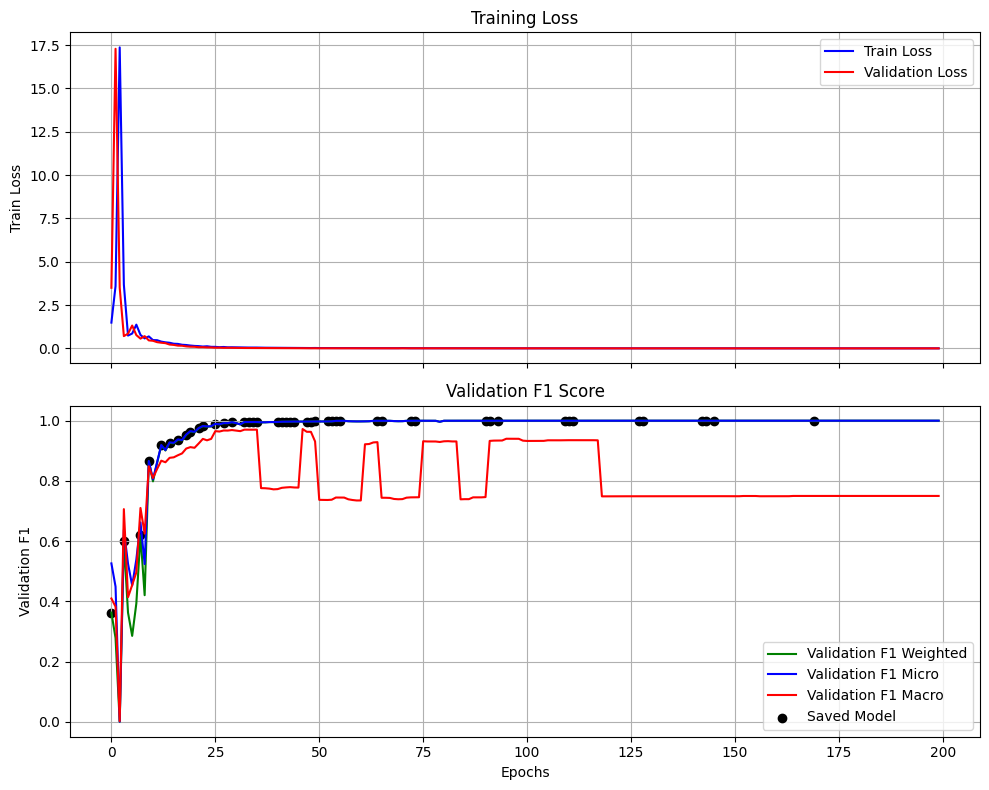

In [ ]:
plot_training_process(train_loss_history, val_loss_history, val_f1_history, saved_model_epochs)

In [ ]:
# Save or Load test_graph_dataset
if os.path.exists(os.path.join(graph_datasets_path, "test_graph_dataset.pth")):  
    test_graph_dataset = th.load(os.path.join(graph_datasets_path, "test_graph_dataset.pth"))
else:       
    th.save(test_graph_dataset, os.path.join(graph_datasets_path, "test_graph_dataset.pth"))

In [ ]:
import torch
from torch_geometric.utils import degree
from collections import defaultdict

def check_global_avg_degrees_per_class(graph_dataset):
    # Dictionaries to hold total degree sums and counts per class
    total_out_deg = defaultdict(float)
    total_in_deg = defaultdict(float)
    count_out_nodes = defaultdict(int)
    count_in_nodes = defaultdict(int)
    min_out_deg = defaultdict(lambda: float('inf'))
    max_out_deg = defaultdict(lambda: float('-inf'))
    min_in_deg = defaultdict(lambda: float('inf'))
    max_in_deg = defaultdict(lambda: float('-inf'))

    for graph in graph_dataset:
        edge_index = graph.edge_index
        edge_label = graph.edge_label
        num_nodes = graph.num_nodes

        unique_classes = torch.unique(edge_label)

        for cls in unique_classes:
            cls = int(cls)
            mask = (edge_label == cls)

            src_nodes = edge_index[0][mask]
            dst_nodes = edge_index[1][mask]

            out_deg = degree(src_nodes, num_nodes=num_nodes)
            in_deg = degree(dst_nodes, num_nodes=num_nodes)

            involved_src = out_deg > 0
            involved_dst = in_deg > 0

            total_out_deg[cls] += out_deg[involved_src].sum().item()
            total_in_deg[cls] += in_deg[involved_dst].sum().item()
            count_out_nodes[cls] += involved_src.sum().item()
            count_in_nodes[cls] += involved_dst.sum().item()

            if involved_src.any():
                min_out_deg[cls] = min(min_out_deg[cls], out_deg[involved_src].min().item())
                max_out_deg[cls] = max(max_out_deg[cls], out_deg[involved_src].max().item())
            if involved_dst.any():
                min_in_deg[cls] = min(min_in_deg[cls], in_deg[involved_dst].min().item())
                max_in_deg[cls] = max(max_in_deg[cls], in_deg[involved_dst].max().item())

    print("Average, Min, and Max Degrees Across All Graphs:")
    class_degree_report = {}
    for cls in sorted(total_out_deg.keys()):
        avg_out = total_out_deg[cls] / count_out_nodes[cls] if count_out_nodes[cls] > 0 else 0.0
        avg_in = total_in_deg[cls] / count_in_nodes[cls] if count_in_nodes[cls] > 0 else 0.0
        min_out = min_out_deg[cls] if min_out_deg[cls] != float('inf') else 0.0
        max_out = max_out_deg[cls] if max_out_deg[cls] != float('-inf') else 0.0
        min_in = min_in_deg[cls] if min_in_deg[cls] != float('inf') else 0.0
        max_in = max_in_deg[cls] if max_in_deg[cls] != float('-inf') else 0.0

        print(f"  Attack Class {le.inverse_transform([cls])}:")
        print(f"    Avg Out-Degree (src): {avg_out:.4f} | Min: {min_out:.0f} | Max: {max_out:.0f}")
        print(f"    Avg In-Degree (dst): {avg_in:.4f} | Min: {min_in:.0f} | Max: {max_in:.0f}")

        class_degree_report[le.inverse_transform([cls])[0]] = {
            "avg_out": avg_out,
            "min_out": min_out,
            "max_out": max_out,
            "avg_in": avg_in,
            "min_in": min_in,
            "max_in": max_in
        }

    # 
    return class_degree_report

class_degree_report = check_global_avg_degrees_per_class(test_graph_dataset)

Average, Min, and Max Degrees Across All Graphs:
  Attack Class ['DDoS']:
    Avg Out-Degree (src): 1.0018 | Min: 1 | Max: 244
    Avg In-Degree (dst): 402.3860 | Min: 1 | Max: 1500
  Attack Class ['DoS']:
    Avg Out-Degree (src): 1.0003 | Min: 1 | Max: 192
    Avg In-Degree (dst): 385.4847 | Min: 1 | Max: 1500
  Attack Class ['Normal']:
    Avg Out-Degree (src): 1.0370 | Min: 1 | Max: 4
    Avg In-Degree (dst): 1.7732 | Min: 1 | Max: 20
  Attack Class ['Reconnaissance']:
    Avg Out-Degree (src): 4.2623 | Min: 1 | Max: 1025
    Avg In-Degree (dst): 1.6132 | Min: 1 | Max: 1495
  Attack Class ['Theft']:
    Avg Out-Degree (src): 1.0128 | Min: 1 | Max: 2
    Avg In-Degree (dst): 11.2857 | Min: 1 | Max: 26


In [ ]:
from torch_geometric.utils import subgraph
from torch_geometric.data import Data
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

def eval(dataset, adversarial=False):

    best_model = EGraphSAGE(node_in_channels=num_features, 
                       edge_in_channels=num_features,
                       hidden_channels=best_hidden_dim, 
                       out_channels=num_classes).to(device)

    print("Loading model from", best_model_path)
    best_model.load_state_dict(th.load(best_model_path))

    best_model.eval()

    print("inference start")
    with th.no_grad():
        all_pred_logits = []
        all_test_labels = []
        for G_pyg in tqdm(dataset, desc="Evaluation", leave=False):
            try:
                # Move the graph data to the device
                G_pyg = G_pyg.to(device)
                G_pyg.edge_label = G_pyg.edge_label.to(device)
                G_pyg.edge_attr = G_pyg.edge_attr.to(device)
                out = best_model(G_pyg)
                
            except Exception as forward_error:
                print(f"Error during forward/backward pass at {forward_error}")

            all_pred_logits.append(out.cpu())
            all_test_labels.append(G_pyg.edge_label.cpu())

        all_pred_logits = th.cat(all_pred_logits).to(device)
        all_test_labels = th.cat(all_test_labels).to(device)
        test_accuracy = compute_accuracy(all_pred_logits, all_test_labels)
        print(f'Test Accuracy: {test_accuracy:.4f}')

        pred_labels = all_pred_logits.argmax(dim=1).cpu()
        all_test_labels = all_test_labels.cpu()
    
    if adversarial:

        # Create a boolean mask where the label is NOT equal to the adversarial class
        adversarial_mask = all_test_labels == ADVERSARIAL_CLASS_LABEL

        # Print the class that the adversarial samples are classified as
        cm_adversarial = confusion_matrix(all_test_labels[adversarial_mask], pred_labels[adversarial_mask], labels=range(len(class_map) + 1))
        print("Adversarial confusion matrix:", cm_adversarial)

        # Apply the mask to both labels and predictions
        all_test_labels = all_test_labels[~adversarial_mask]
        pred_labels = pred_labels[~adversarial_mask]

    print("class_map", class_map)
    # Generate a report
    cm = confusion_matrix(all_test_labels, pred_labels, labels=range(len(class_map)))
    print(cm)

    report = classification_report(all_test_labels, pred_labels, target_names=class_map, digits=4)
    print(report)
    
    return classification_report(all_test_labels, pred_labels, target_names=class_map, digits=4, output_dict=True)


print("Number of test graphs: ", len(test_graph_dataset))
normal_report = eval(test_graph_dataset)


Number of test graphs:  366
Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/BoT_IoT/strat_window_combined_port/best_model_all_raw.pth
inference start


Evaluation:  15%|█▍        | 54/366 [00:00<00:00, 535.92it/s]

Test Accuracy: 0.9968
class_map ['DDoS' 'DoS' 'Normal' 'Reconnaissance' 'Theft']
[[287994   1500      3      3      0]
 [     0 247436      2      3      0]
 [     0      0     28      0      0]
 [    79    156     25  11764      7]
 [     0      0      0      0      0]]
                precision    recall  f1-score   support

          DDoS     0.9997    0.9948    0.9973    289500
           DoS     0.9934    1.0000    0.9967    247441
        Normal     0.4828    1.0000    0.6512        28
Reconnaissance     0.9995    0.9778    0.9885     12031
         Theft     0.0000    0.0000    0.0000         0

      accuracy                         0.9968    549000
     macro avg     0.6951    0.7945    0.7267    549000
  weighted avg     0.9968    0.9968    0.9968    549000



/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [ ]:
def inject_traffic_to_node(graph, ratio=0.1, num_injected_nodes=1, to_node_type='both', random_seed=42):
    edge_index = graph.edge_index.clone()
    edge_attr = graph.edge_attr.clone()
    edge_label = graph.edge_label.clone()
    x = graph.x.clone()

    num_edges = edge_index.size(1)
    feature_dim = graph.x.size(1)

    # Get all src nodes
    if to_node_type == 'src':
         to_nodes = edge_index[0]

    elif to_node_type == 'dst':
         to_nodes = edge_index[1]

    elif to_node_type == 'both':
         to_nodes = th.cat([edge_index[0], edge_index[1]])

    else:
        raise ValueError("to_node_type must be 'src', 'dst', or 'both'.")

    original_num_nodes = x.size(0)

    new_node_feats = th.ones((num_injected_nodes, feature_dim))
    x = th.cat([x, new_node_feats], dim=0)

    # 4. Inject edges from injected nodes to attacker nodes
    num_to_inject = max(1, int(ratio * num_edges))
    new_edges = []
    new_attrs = []
    new_labels = []
    
    for i in range(num_to_inject):
        rng = random.Random(random_seed + i)  # ensure different seed per iteration
        src = rng.randint(original_num_nodes, original_num_nodes + num_injected_nodes - 1)  # from injected nodes
        dst = rng.choice(to_nodes.tolist())  # to existing nodes

        new_edges.append([src, dst])
        attr = th.rand(feature_dim)  # random feature for the new edge
        new_attrs.append(attr)
        new_labels.append(ADVERSARIAL_CLASS_LABEL)

    # Create a new empty graph to store the injected edges
    new_graph = Data()

    # 5. Merge into graph
    if new_edges:
        new_edges = th.tensor(new_edges, dtype=th.long).t().contiguous()
        new_attrs = th.stack(new_attrs)
        new_labels = th.tensor(new_labels, dtype=th.long)

        new_graph.edge_index = th.cat([edge_index, new_edges], dim=1)
        new_graph.edge_attr = th.cat([edge_attr, new_attrs], dim=0)
        new_graph.edge_label = th.cat([edge_label, new_labels], dim=0)
        new_graph.x = x

    return new_graph



In [ ]:
# Inject Attack Traffic to Attacker Nodes
inject_both_graph_dataset = [inject_traffic_to_node(g.cpu(), 0.1, num_injected_nodes=1, to_node_type='both') for g in test_graph_dataset]
inject_both_report = eval(inject_both_graph_dataset, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/BoT_IoT/strat_window_combined_port/best_model_all_raw.pth
inference start


/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 0.6709
Adversarial confusion matrix: [[    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [  361     4    83 54452     0     0]]
class_map ['DDoS' 'DoS' 'Normal' 'Reconnaissance' 'Theft']
[[287837      0      2   1661      0]
 [126851 111718    146   8726      0]
 [     0      0     28      0      0]
 [  6350    117     12   5545      7]
 [     0      0      0      0      0]]
                precision    recall  f1-score   support

          DDoS     0.6836    0.9943    0.8102    289500
           DoS     0.9990    0.4515    0.6219    247441
        Normal     0.1489    1.0000    0.2593        28
Reconnaissance     0.3480    0.4609    0.3966     12031
         Theft     0.0000    0.0000    0.0000         0

      accuracy                         0.7379    549000
     macro avg     0.4359    0.5813    0.4176    549000
  weighted av

/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Inject Attack Traffic to Attacker Nodes
inject_src_graph_dataset = [inject_traffic_to_node(g.cpu(), 0.1, num_injected_nodes=1, to_node_type='src') for g in test_graph_dataset]
inject_src_report = eval(inject_src_graph_dataset, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/BoT_IoT/strat_window_combined_port/best_model_all_raw.pth
inference start


/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 0.8794
Adversarial confusion matrix: [[    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [29480 22970     2  2448     0     0]]
class_map ['DDoS' 'DoS' 'Normal' 'Reconnaissance' 'Theft']
[[289488      0      3      9      0]
 [  5646 229779     13  12003      0]
 [     0      0     28      0      0]
 [    73    140     14  11797      7]
 [     0      0      0      0      0]]
                precision    recall  f1-score   support

          DDoS     0.9806    1.0000    0.9902    289500
           DoS     0.9994    0.9286    0.9627    247441
        Normal     0.4828    1.0000    0.6512        28
Reconnaissance     0.4955    0.9806    0.6583     12031
         Theft     0.0000    0.0000    0.0000         0

      accuracy                         0.9674    549000
     macro avg     0.5917    0.7818    0.6525    549000
  weighted av

/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Inject Attack Traffic to Attacker Nodes
inject_dst_graph_dataset = [inject_traffic_to_node(g.cpu(), 0.1, num_injected_nodes=1, to_node_type='dst') for g in test_graph_dataset]
inject_dst_report = eval(inject_dst_graph_dataset, adversarial=True)

In [ ]:
# Edge Attribute Perturbation
def perturb_edge_attributes(graph, affected_edge_ratio=0.1, perturbation_ratio=0.1, random_seed=42):
    edge_index = graph.edge_index.clone()
    edge_attr = graph.edge_attr.clone()
    edge_label = graph.edge_label.clone()

    num_edges = edge_index.size(1)
    feature_dim = edge_attr.size(1)

    # Randomly select edges to perturb
    num_to_perturb = max(1, int(affected_edge_ratio * num_edges))
    rng = random.Random(random_seed)
    indices_to_perturb = rng.sample(range(num_edges), num_to_perturb)

    for idx in indices_to_perturb:
        # Perturb the edge attributes by adding noise
        noise = th.randn(feature_dim) * perturbation_ratio  # Adjust the scale of noise as needed
        edge_attr[idx] += noise

    # Create a new graph with perturbed attributes
    perturbed_graph = Data(edge_index=edge_index, edge_attr=edge_attr, edge_label=edge_label, x=graph.x)

    return perturbed_graph

In [ ]:
# Edge Attribute Perturbation
edge_perturb_graph_dataset = [perturb_edge_attributes(g.cpu(), affected_edge_ratio=1, perturbation_ratio=10) for g in test_graph_dataset]
edge_perturb_report = eval(edge_perturb_graph_dataset, adversarial=True)

In [ ]:
# Inject Random Edges
def inject_random_edges(graph, ratio=0.1, random_seed=42):
    edge_index = graph.edge_index.clone()
    edge_attr = graph.edge_attr.clone()
    edge_label = graph.edge_label.clone()
    x = graph.x.clone()

    num_nodes = x.size(0)
    feature_dim = graph.x.size(1)

    new_edge_indices = []
    new_edge_attrs = []
    new_edge_labels = []

    num_edges = edge_index.size(1)
    num_injected_edges = max(1, int(ratio * num_edges))

    for i in range(num_injected_edges):
        rng = random.Random(random_seed + i)  # ensure different seed per edge
        src = rng.randint(0, num_nodes - 1)  # Random source node
        dst = rng.randint(0, num_nodes - 1)  # Random destination node

        new_edge_indices.append([src, dst])
        new_edge_attrs.append(th.rand(feature_dim))  # Random feature for the new edge
        new_edge_labels.append(ADVERSARIAL_CLASS_LABEL)

    if new_edge_indices:
        new_edge_indices = th.tensor(new_edge_indices, dtype=th.long).t().contiguous()
        new_edge_attrs = th.stack(new_edge_attrs)
        new_edge_labels = th.tensor(new_edge_labels, dtype=th.long)

        edge_index = th.cat([edge_index, new_edge_indices], dim=1)
        edge_attr = th.cat([edge_attr, new_edge_attrs], dim=0)
        edge_label = th.cat([edge_label, new_edge_labels], dim=0)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, edge_label=edge_label)

In [ ]:
# Inject Random Edges
random_edge_graph_dataset = [inject_random_edges(g.cpu(), 0.1) for g in test_graph_dataset]
random_edge_report = eval(random_edge_graph_dataset, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/BoT_IoT/strat_window_combined_port/best_model_all_raw.pth
inference start


/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 0.6809
Adversarial confusion matrix: [[    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [ 2269    33    96 52501     1     0]]
class_map ['DDoS' 'DoS' 'Normal' 'Reconnaissance' 'Theft']
[[288001      0      3   1496      0]
 [127293 111563    154   8431      0]
 [     0      0     24      3      1]
 [   248    128     13  11635      7]
 [     0      0      0      0      0]]
                precision    recall  f1-score   support

          DDoS     0.6931    0.9948    0.8170    289500
           DoS     0.9989    0.4509    0.6213    247441
        Normal     0.1237    0.8571    0.2162        28
Reconnaissance     0.5395    0.9671    0.6926     12031
         Theft     0.0000    0.0000    0.0000         0

      accuracy                         0.7490    549000
     macro avg     0.4710    0.6540    0.4694    549000
  weighted av

/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
def compare_overall_metrics(baseline_report, adversarial_reports):
    rows = []   
    metrics = ['precision', 'recall', 'f1-score']

    for label in class_map + ['macro avg', 'weighted avg',]:
        row = {"Class": label}
        row['support'] = baseline_report[label]['support']
        for metric in metrics:
            baseline_val = baseline_report[label][metric]
            row[f"Normal_{metric}"] = baseline_val
            for name, report in adversarial_reports.items():
                adv_val = report[label][metric]
                row[f"{name}_{metric}"] = adv_val
                row[f"{name}_{metric}_drop(%)"] = ((baseline_val - adv_val) / baseline_val) * 100
        rows.append(row)

    return pd.DataFrame(rows)

adversarial_reports = {
    "Injected Both": inject_both_report,
    "Injected Src": inject_src_report,
    "Injected Dst": inject_dst_report,
    "Edge Perturbation": edge_perturb_report,
    "Random Edge": random_edge_report,
}

comparison_df = compare_overall_metrics(normal_report, adversarial_reports)

normal_cols = [col for col in comparison_df.columns if col.startswith('Normal_')] 
percentage_drop_cols = [col for col in comparison_df.columns if col.endswith('_drop(%)')]

percentage_drop_df = pd.concat([comparison_df[normal_cols], comparison_df[percentage_drop_cols]], axis=1)

print("Comparison of Overall Metrics:")
print(percentage_drop_df)